In [1]:
import sys 
import numpy as np
import h5py 
import copy
from multiprocessing import Pool, cpu_count
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from matplotlib.patches import Patch, Rectangle, Arrow, FancyArrow
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

import gpder
from gpder import GaussianProcessRegressor
from gpder.gaussian_process.kernels import RegularKernel
from gpder.gaussian_process.kernels import DerivativeKernel
from gpder import GPUncertaintyOptimizer, NetVarianceLoss

In [5]:
f = h5py.File("../../demos/HEP_2D/three_jets_30k.h5", "r")
J1_threeM = np.array(f["j1_threeM"])
J2_threeM = np.array(f["j2_threeM"])
J3_threeM = np.array(f["j3_threeM"])
threeM = np.stack((J1_threeM, J2_threeM, J3_threeM), axis=1)
f.close()

/tmp/ipykernel_1229618/34128670.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  J1_threeM = np.array(f["j1_threeM"])
/tmp/ipykernel_1229618/34128670.py:3: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  J2_threeM = np.array(f["j2_threeM"])
/tmp/ipykernel_1229618/34128670.py:4: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  J3_threeM = np.array(f["j3_threeM"])


In [24]:
import sys
sys.path.append("../../demos/HEP_2D")

from hep_functions import efficiency
from hep_functions import der_efficiency

def efficiency_events(X, threeM=threeM, normalized=True):
    return efficiency(X, events_threeM=threeM, normalized=normalized)

def der_efficiency_events_sigmoid10(X, threeM=threeM):
    return der_efficiency(X, events_threeM=threeM, a=1/10)

# Figure 5

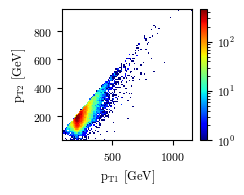

In [8]:
plt.rcParams.update({'text.usetex': False,
                     'font.family': 'serif',
                     'font.size': 8.5,
                     'font.serif': 'cmr10',
                     'mathtext.fontset': 'cm',
                     'axes.formatter.use_mathtext': True})

my_cmap = plt.cm.jet
my_cmap.set_under('w',1)
plt.figure(figsize=(2.1, 1.7))
plt.hist2d(J1_threeM[:, 0], J2_threeM[:, 0], bins=100,
           norm=LogNorm(),
           cmap=my_cmap
          )
plt.colorbar()
plt.xlabel(r"$\mathrm{p}_{\mathrm{T} 1}$ [GeV]", fontsize=9)
plt.ylabel(r"$\mathrm{p}_{\mathrm{T} 2}$ [GeV]", fontsize=9)
plt.savefig("hep2d_pTdist.pdf", bbox_inches="tight", pad_inches=0.03, dpi=400)
plt.show()

# Figure 6

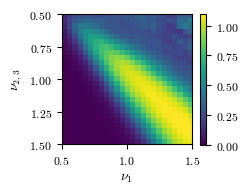

In [10]:
res = 25
X_lower = 0.5
X_upper = 1.5
lin = np.linspace(X_lower, X_upper, res)
nuJ1_test, nuJ23_test = np.meshgrid(lin, lin)
X_test = np.vstack((nuJ1_test.flatten(), nuJ23_test.flatten())).T 
y_test = Pool(cpu_count()).map(efficiency_events, X_test)
y_test = np.array(y_test)

plt.rcParams.update({'text.usetex': False,
                     'font.family': 'serif',
                     'font.size': 8.5,
                     'font.serif': 'cmr10',
                     'mathtext.fontset': 'cm',
                     'axes.formatter.use_mathtext': True})

plt.figure(figsize=(2.1, 1.7))
plt.imshow(y_test.reshape(res, res), 
           origin='upper', 
           extent=[X_lower, X_upper, X_upper, X_lower],
           vmin=0, vmax=1.1
          )
plt.colorbar(ticks=[0, 0.25, 0.5, 0.75, 1])
plt.xlabel(r'$\nu_{1}$', fontsize=10)
plt.ylabel(r'$\nu_{2,3}$', fontsize=10)
plt.yticks([0.5, 0.75, 1.0, 1.25, 1.5])
plt.savefig('hep2d_true.pdf', bbox_inches="tight", pad_inches=0.03, dpi=400)
plt.show()

# Figure 7

In [16]:
def efficiency_unnormalized(X):
    return efficiency_events(X, normalized=False)

def generate_X_onaxis(res):
    X_coords = np.linspace(np.repeat(X_lower, 2), np.repeat(X_upper, 2), res)
    n = len(X_coords)
    X_grid = np.ones((n*2, 2))
    for i in range(2):
        X_grid[i*n:(i+1)*n, i] = X_coords[:, i]
    X_grid_set = set()
    for x in X_grid:
        tupl = tuple(x)
        if tupl not in X_grid_set:
            X_grid_set.add(tupl)
    return np.array(list(X_grid_set))

In [19]:
X_onaxis = generate_X_onaxis(res=25)
y_onaxis = Pool(cpu_count()).map(efficiency_unnormalized, X_onaxis)
y_onaxis = np.array(y_onaxis).reshape(-1,)

def onaxis_regression(nuJ1, nuJ23, X_onaxis=X_onaxis, y_onaxisy=y_onaxis):
    nuJ1_ix = np.where((X_onaxis[:, 0] == nuJ1) & (X_onaxis[:, 1] == 1))
    nuJ23_ix = np.where((X_onaxis[:, 0] == 1) & (X_onaxis[:, 1] == nuJ23))
    return y_onaxis[nuJ1_ix] * y_onaxis[nuJ23_ix]

y_OAR = Pool(cpu_count()).starmap(onaxis_regression, X_test)
y_OAR = np.array(y_OAR).reshape(-1,)

# making sure the on-axis regression are the equal to the true values
# this is easier than using if statements in the onaxis_regression function 
for i, x in enumerate(X_onaxis):
    ix = np.where((X_test[:, 0] == x[0]) & (X_test[:, 1] == x[1]))
    y_OAR[ix] = y_onaxis[i]

# normalization
norm = efficiency_unnormalized((1, 1))
y_OAR /= norm

mse_OAR = np.mean((y_OAR.ravel() - y_test.ravel())**2)

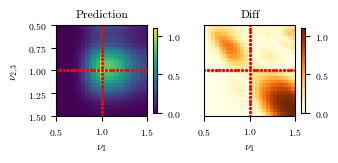

In [20]:
plt.rcParams.update({'text.usetex': False,
                     'font.family': 'serif',
                     'font.size': 7,
                     'font.serif': 'cmr10',
                     'mathtext.fontset': 'cm',
                     'axes.formatter.use_mathtext': True})

fig, ax = plt.subplots(1, 2, figsize=(3+3/8, 1.3), sharey=True)
plt.subplots_adjust(wspace=0.3)
res = res
im0 = ax[0].imshow(y_OAR.reshape(res, res), 
                   extent=[X_lower, X_upper, X_upper, X_lower],
                   vmin=0, vmax=1.1)
plt.colorbar(im0, ax=ax[0], shrink=0.85, ticks=[0, 0.5, 1])
ax[0].set_xlabel(r"$\nu_{1}$", fontsize=8)
ax[0].set_ylabel(r"$\nu_{2,3}$", fontsize=8)
ax[0].set_title("Prediction")
ax[0].set_xlim(0.5, 1.5)
ax[0].set_ylim(1.5, 0.5)

diff = np.abs(y_OAR.ravel() - y_test.ravel()).reshape(res, res)
im1 = ax[1].imshow(diff, 
                   extent=[X_lower, X_upper, X_upper, X_lower],
                   cmap='YlOrBr',
                   vmin=0, vmax=1.1)
plt.colorbar(im1, ax=ax[1], shrink=0.85, ticks=[0, 0.5, 1])
ax[1].set_xlabel(r"$\nu_{1}$", fontsize=8)
ax[1].set_title("Diff")
ax[1].set_xlim(0.5, 1.5)
ax[1].set_ylim(1.5, 0.5)

ax[0].scatter(X_onaxis[:, 0], X_onaxis[:, 1],
              color='red', s=2, label='Observations')
ax[1].scatter(X_onaxis[:, 0], X_onaxis[:, 1],
              color='red', s=2, label='Observations')

ax[1].tick_params(axis='y', left=False)

plt.savefig('hep2d_onaxis.pdf', bbox_inches="tight", pad_inches=0.03, dpi=400)
plt.show()

# Figure 8 (a)

In [21]:
amplitude = np.sqrt(0.1)
length_scale = 0.25
noise_level = np.sqrt(1e-4)
noise_level_der = np.sqrt(1e-1)
n_restarts_optimizer = 20

In [25]:
# -- Test dataset ---------------------------------------------------------- #
res_test = 25
X_lower, X_upper = 0.5, 1.5
lin = np.linspace(X_lower, X_upper, res_test)
nu_J1_test, nu_J23_test = np.meshgrid(lin, lin)
X_test = np.array([nu_J1_test.flatten(), nu_J23_test.flatten()]).T
y_test = Pool(cpu_count()).map(efficiency_events, X_test)
y_test = np.array(y_test)
# -------------------------------------------------------------------------- #

# -- Trainning dataset ----------------------------------------------------- #
nu_J1_train = [0.7, 1.0, 1.0, 1.0, 1.3]
nu_J23_train = [1.0, 0.7, 1.0, 1.3, 1.0]
X_train = np.array([nu_J1_train, nu_J23_train]).T
y_train = Pool(cpu_count()).map(efficiency_events, X_train)
y_train = np.array(y_train)
dy_train = Pool(cpu_count()).map(der_efficiency_events_sigmoid10, X_train)
dy_train = np.array(dy_train)
# -------------------------------------------------------------------------- #

In [26]:
def fill_image(image, ax, title, preds=False, X_train=None, cmap='viridis', vmin=0, vmax=1, cbarticks=None):

    extent = [0.5, 1.5, 1.5, 0.5]
    im = ax.imshow(image, origin='upper', extent=extent, cmap=cmap, vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(im, ax=ax, shrink=0.6, ticks=cbarticks)
    cbar.ax.tick_params(labelsize=8, pad=1)
    cbar.formatter.set_powerlimits((0, 0))
    cbar.ax.yaxis.set_offset_position('left')    
    if X_train is not None:
        if X_train.shape[0] > 5:
            ax.scatter(X_train[:5, 0], X_train[:5, 1], color='#FA0000', s=2, label='Initial obs.')
            ax.scatter(X_train[5:, 0], X_train[5:, 1], color='#FB56F6', s=2, label='Bayes obs.')
        else:
            ax.scatter(X_train[:5, 0], X_train[:5, 1], color='#FA0000', s=2, label='Observations')
    ax.set_title(title, pad=3)
    ax.set_xlabel(r'$\nu_{1}$', fontsize=8, labelpad=0.5)
    if preds:
        ax.set_ylabel(r'$\nu_{2,3}$', fontsize=8, labelpad=0.5)
    ax.tick_params(axis='both', which='major')
    ax.set_xlim(0.5, 1.5)
    ax.set_ylim(1.5, 0.5)
    ax.tick_params(axis='both', labelsize=7, which='major', pad=1)
    return im

0.316**2 * RBF(length_scale=0.25) + WhiteKernel(noise_level=0.01)


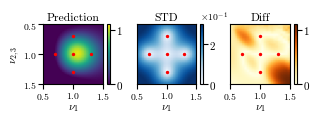

In [27]:
kernel = RegularKernel(amplitude=amplitude, length_scale=length_scale, noise_level=noise_level)
gp_reg = GaussianProcessRegressor(kernel=kernel, optimizer=None, random_state=42)
gp_reg.fit(X_train, y_train)
print(gp_reg.kernel)

plt.rcParams.update({'text.usetex': False,
                     'font.family': 'serif',
                     'font.size': 7,
                     'font.serif': 'cmr10',
                     'mathtext.fontset': 'cm',
                     'axes.formatter.use_mathtext': True})

fig, ax = plt.subplots(1, 3, figsize=((3+3/8), 1.3), sharey=True)
y_pred, y_std = gp_reg.predict(X_test, return_std=True)
plt.subplots_adjust(wspace=0.25)
im0 = fill_image(y_pred.reshape(res, res), ax[0], 
                 X_train=gp_reg.X_train, preds=True, 
                 title="Prediction", 
                 vmin=0, vmax=1.1, cbarticks=[0, 1])
im1 = fill_image(y_std.reshape(res, res), ax[1], 
                 X_train=gp_reg.X_train, 
                 title="STD", cmap='Blues', 
                 vmin=0, vmax=0.3, cbarticks=[0, 0.2])
diff = np.abs(y_test - y_pred.ravel())
im2 = fill_image(diff.reshape(res, res), ax[2], 
                 X_train=gp_reg.X_train, 
                 title="Diff", cmap='YlOrBr', 
                 vmin=0, vmax=1.1, cbarticks=[0, 1])

ax[1].tick_params(axis='y', left=False)
ax[2].tick_params(axis='y', left=False)

plt.savefig('hep2d_regGPR.pdf', bbox_inches="tight", pad_inches=0.03, dpi=400)
plt.show()

# Figure 8 (b)

0.316**2 * DerivativeRBF(length_scale=0.25) + WhiteKernel(noise_level=0.01) + WhiteKernel_der(noise_level=0.316)


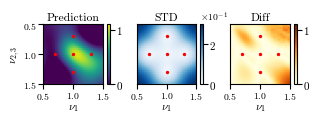

In [28]:
kernel = DerivativeKernel(amplitude=amplitude, length_scale=length_scale, noise_level=noise_level, noise_level_der=noise_level_der)
gp_der = GaussianProcessRegressor(kernel=kernel, optimizer=None, random_state=42)
gp_der.fit(X_train, y_train, X_train, dy_train)
print(gp_der.kernel)

plt.rcParams.update({'text.usetex': False,
                     'font.family': 'serif',
                     'font.size': 7,
                     'font.serif': 'cmr10',
                     'mathtext.fontset': 'cm',
                     'axes.formatter.use_mathtext': True})

fig, ax = plt.subplots(1, 3, figsize=((3+3/8), 1.3), sharey=True)
y_pred, y_std = gp_der.predict(X_test, return_std=True)
plt.subplots_adjust(wspace=0.25)
im0 = fill_image(y_pred.reshape(res, res), ax[0], 
                 X_train=gp_der.X_train, preds=True, 
                 title="Prediction", 
                 vmin=0, vmax=1.1, 
                 cbarticks=[0, 1])
im1 = fill_image(y_std.reshape(res, res), ax[1], 
                 X_train=gp_der.X_train, 
                 title="STD", cmap='Blues', 
                 vmin=0, vmax=0.3, cbarticks=[0, 0.2])
diff = np.abs(y_test - y_pred.ravel())
im2 = fill_image(diff.reshape(res, res), ax[2], 
                 X_train=gp_der.X_train, 
                 title="Diff", cmap='YlOrBr', 
                 vmin=0, vmax=1.1, cbarticks=[0, 1])

ax[1].tick_params(axis='y', left=False)
ax[2].tick_params(axis='y', left=False)

plt.savefig('hep2d_derGPR.pdf', bbox_inches="tight", pad_inches=0.03, dpi=400)

# Figure 9 (a)

0.316**2 * RBF(length_scale=0.25) + WhiteKernel(noise_level=0.01)


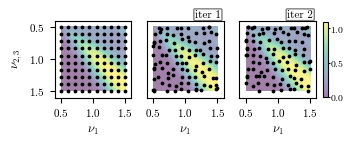

In [30]:
# -- Utility input --------------------------------------------------------- #
lin = np.linspace(X_lower, X_upper, 10)
nuJ1_util, nuJ23_util = np.meshgrid(lin, lin)
X_util_10 = np.vstack((nuJ1_util.flatten(), nuJ23_util.flatten())).T
# -------------------------------------------------------------------------- #

kernel = RegularKernel(amplitude=amplitude, length_scale=length_scale, noise_level=noise_level)
gp_reg = GaussianProcessRegressor(kernel=kernel, optimizer=None, random_state=42)
gp_reg.fit(X_train, y_train)
print(gp_reg.kernel)

BED_reg = GPUncertaintyOptimizer(
    gp_model=gp_reg,
    bounds={"nu_J1": (X_lower, X_upper), "nu_J23": (X_lower, X_upper)},
    function=efficiency_events,
    random_state=42,
    verbose=False,
)

X_util_iter = np.zeros((3, X_util_10.shape[0], X_util_10.shape[1]))
X_util_iter[0] = X_util_10

for i in range(2):
    gp_reg = BED_reg.minimize_variance(
        X_util=X_util_10, n_iters=1, n_restarts_optimizer=n_restarts_optimizer, gamma=np.sqrt(1/50),
    )
    X_util_iter[i + 1] = BED_reg._X_util_temp

plt.rcParams.update({'text.usetex': False,
                     'font.family': 'serif',
                     'font.size': 8,
                     'font.serif': 'cmr10',
                     'mathtext.fontset': 'cm',
                     'axes.formatter.use_mathtext': True})

fig, ax = plt.subplots(1, 3, figsize=(3+3/8, 1), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.2, hspace=0.35)

for i in range(3):
    im = ax[i].imshow(y_test.reshape(res, res), origin='upper', 
                     extent=[X_lower, X_upper, X_upper, X_lower],
                     vmin=0, vmax=1.1, alpha=0.5)
    ax[i].set_xlim(0.4, 1.6)
    ax[i].set_ylim(1.6, 0.4)
    ax[i].set_xlabel(r'$\nu_{1}$', fontsize=9)

ax[0].scatter(X_util_iter[0][:, 0], X_util_iter[0][:, 1], s=3, color='black')
ax[1].scatter(X_util_iter[1][:, 0], X_util_iter[1][:, 1], s=3, color='black')
ax[2].scatter(X_util_iter[2][:, 0], X_util_iter[2][:, 1], s=3, color='black')

props = dict(boxstyle='round', facecolor='white', alpha=0.5, pad=0.1)
ax[1].text(1.15, 0.35, "iter {}".format(1), zorder=6, bbox=props)
ax[2].text(1.15, 0.35, "iter {}".format(2), zorder=6, bbox=props)

ax[0].set_ylabel(r'$\nu_{2,3}$', fontsize=9)

ax[1].tick_params(axis='y', left=False)
ax[2].tick_params(axis='y', left=False)

cbar_ax = fig.add_axes([0.92, 0.12, 0.016, 0.75])
cbar = fig.colorbar(im, cax=cbar_ax, ticks=[0, 0.5, 1])
cbar.ax.tick_params(labelsize=7, length=1.5, pad=0.1)

plt.savefig('noisy_grids_Xu10.pdf', bbox_inches="tight", pad_inches=0.03, dpi=400)

plt.show()


# Figure 9 (b)

0.316**2 * RBF(length_scale=0.25) + WhiteKernel(noise_level=0.01)


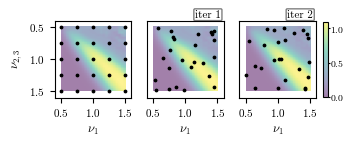

In [31]:
# -- Utility input --------------------------------------------------------- #
lin = np.linspace(X_lower, X_upper, 5)
nuJ1_util, nuJ23_util = np.meshgrid(lin, lin)
X_util_5 = np.vstack((nuJ1_util.flatten(), nuJ23_util.flatten())).T
# -------------------------------------------------------------------------- #

kernel = RegularKernel(amplitude=amplitude, length_scale=length_scale, noise_level=noise_level)
gp_reg = GaussianProcessRegressor(kernel=kernel, optimizer=None, random_state=42)
gp_reg.fit(X_train, y_train)
print(gp_reg.kernel)

BED_reg = GPUncertaintyOptimizer(
    gp_model=gp_reg,
    bounds={"nu_J1": (X_lower, X_upper), "nu_J23": (X_lower, X_upper)},
    function=efficiency_events,
    random_state=42,
    verbose=False,
)

X_util_iter = np.zeros((3, X_util_5.shape[0], X_util_5.shape[1]))
X_util_iter[0] = X_util_5

for i in range(2):
    gp_reg = BED_reg.minimize_variance(
        X_util=X_util_5, n_iters=1, n_restarts_optimizer=n_restarts_optimizer, gamma=np.sqrt(1/10),
    )
    X_util_iter[i + 1] = BED_reg._X_util_temp

plt.rcParams.update({'text.usetex': False,
                     'font.family': 'serif',
                     'font.size': 8,
                     'font.serif': 'cmr10',
                     'mathtext.fontset': 'cm',
                     'axes.formatter.use_mathtext': True})

fig, ax = plt.subplots(1, 3, figsize=(3+3/8, 1), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.2, hspace=0.35)

for i in range(3):
    im = ax[i].imshow(y_test.reshape(res, res), origin='upper', 
                     extent=[X_lower, X_upper, X_upper, X_lower],
                     vmin=0, vmax=1.1, alpha=0.5)
    ax[i].set_xlim(0.4, 1.6)
    ax[i].set_ylim(1.6, 0.4)
    ax[i].set_xlabel(r'$\nu_{1}$', fontsize=9)

ax[0].scatter(X_util_iter[0][:, 0], X_util_iter[0][:, 1], s=3, color='black')
ax[1].scatter(X_util_iter[1][:, 0], X_util_iter[1][:, 1], s=3, color='black')
ax[2].scatter(X_util_iter[2][:, 0], X_util_iter[2][:, 1], s=3, color='black')

props = dict(boxstyle='round', facecolor='white', alpha=0.5, pad=0.1)
ax[1].text(1.15, 0.35, "iter {}".format(1), zorder=6, bbox=props)
ax[2].text(1.15, 0.35, "iter {}".format(2), zorder=6, bbox=props)

ax[0].set_ylabel(r'$\nu_{2,3}$', fontsize=9)

ax[1].tick_params(axis='y', left=False)
ax[2].tick_params(axis='y', left=False)

cbar_ax = fig.add_axes([0.92, 0.12, 0.016, 0.75])
cbar = fig.colorbar(im, cax=cbar_ax, ticks=[0, 0.5, 1])
cbar.ax.tick_params(labelsize=7, length=1.5, pad=0.1)

plt.savefig('noisy_grids_Xu5.pdf', bbox_inches="tight", pad_inches=0.03, dpi=400)

plt.show()


# Figure 10 (a)

In [34]:
def BED_regGP(X_util_dim, gamma, n):
    # -- Utility input --------------------------------------------------------- #
    lin = np.linspace(X_lower, X_upper, X_util_dim)
    nuJ1_util, nuJ23_util = np.meshgrid(lin, lin)
    X_util = np.vstack((nuJ1_util.flatten(), nuJ23_util.flatten())).T
    # -------------------------------------------------------------------------- #

    gp_reg_mse = np.zeros((n, 45))
    gp_reg_uncert = np.zeros((n, 45))

    for i in range(n):
        kernel = RegularKernel(amplitude=amplitude, length_scale=length_scale, noise_level=noise_level)
        gp_reg = GaussianProcessRegressor(kernel=kernel, optimizer=None, random_state=42+i)
        gp_reg.fit(X_train, y_train)

        y_pred, std = gp_reg.predict(X_test, return_std=True)
        _, cov = gp_reg.predict(X_test, return_cov=True)
        gp_reg_mse[i, 0] = np.mean((y_test.ravel() - y_pred.ravel())**2)
        gp_reg_uncert[i, 0] = np.trace(cov)

        BED_reg = GPUncertaintyOptimizer(
            gp_model=gp_reg,
            bounds={"nu_J1": (X_lower, X_upper), "nu_J23": (X_lower, X_upper)},
            function=efficiency_events,
            random_state=42+i,
            verbose=False,
        )

        for j in range(44):
            gp_reg = BED_reg.minimize_variance(
                X_util=X_util, n_iters=1, n_restarts_optimizer=n_restarts_optimizer, gamma=gamma,
            )
            y_pred, std = gp_reg.predict(X_test, return_std=True)
            _, cov = gp_reg.predict(X_test, return_cov=True)
            gp_reg_mse[i, j+1] = np.mean((y_test.ravel() - y_pred.ravel())**2)
            gp_reg_uncert[i, j+1] = np.trace(cov)
    return gp_reg_mse, gp_reg_uncert

In [35]:
gp_reg_mse_Xu5_g10, gp_reg_uncert_Xu5_g10 = BED_regGP(X_util_dim=5, gamma=np.sqrt(1/10), n=5)
gp_reg_mse_Xu5_g0, gp_reg_uncert_Xu5_g0 = BED_regGP(X_util_dim=5, gamma=0, n=5)

gp_reg_mse_Xu10_g50, gp_reg_uncert_Xu10_g50 = BED_regGP(X_util_dim=10, gamma=np.sqrt(1/50), n=5)
gp_reg_mse_Xu10_g0, gp_reg_uncert_Xu10_g0 = BED_regGP(X_util_dim=10, gamma=0, n=5)

gp_reg_mse_Xu25_g125, gp_reg_uncert_Xu25_g125 = BED_regGP(X_util_dim=25, gamma=np.sqrt(1/125), n=5)
gp_reg_mse_Xu25_g0, gp_reg_uncert_Xu25_g0 = BED_regGP(X_util_dim=25, gamma=0, n=5)

In [42]:
# f = h5py.File("./gp_reg_mse_uncert.h5", "w")
# # X_util_dim = 5
# f.create_dataset("gp_reg_mse_Xu5_g10", data=gp_reg_mse_Xu5_g10)
# f.create_dataset("gp_reg_uncert_Xu5_g10", data=gp_reg_uncert_Xu5_g10)
# f.create_dataset("gp_reg_mse_Xu5_g0", data=gp_reg_mse_Xu5_g0)
# f.create_dataset("gp_reg_uncert_Xu5_g0", data=gp_reg_uncert_Xu5_g0)
# # X_util_dim = 10
# f.create_dataset("gp_reg_mse_Xu10_g50", data=gp_reg_mse_Xu10_g50)
# f.create_dataset("gp_reg_uncert_Xu10_g50", data=gp_reg_uncert_Xu10_g50)
# f.create_dataset("gp_reg_mse_Xu10_g0", data=gp_reg_mse_Xu10_g0)
# f.create_dataset("gp_reg_uncert_Xu10_g0", data=gp_reg_uncert_Xu10_g0)
# # X_util_dim = 25
# f.create_dataset("gp_reg_mse_Xu25_g125", data=gp_reg_mse_Xu25_g125)
# f.create_dataset("gp_reg_uncert_Xu25_g125", data=gp_reg_uncert_Xu25_g125)
# f.create_dataset("gp_reg_mse_Xu25_g0", data=gp_reg_mse_Xu25_g0)
# f.create_dataset("gp_reg_uncert_Xu25_g0", data=gp_reg_uncert_Xu25_g0)
# f.close()

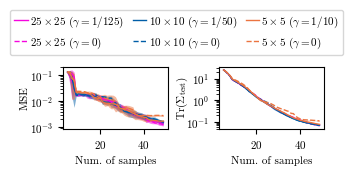

In [36]:
plt.rcParams.update({'text.usetex': False,
                     'font.family': 'serif',
                     'font.size': 8,
                     'font.serif': 'cmr10',
                     'mathtext.fontset': 'cm',
                     'axes.formatter.use_mathtext': True})

fig, ax = plt.subplots(1, 2, figsize=(3+3/8, 0.8))
plt.subplots_adjust(wspace=0.48)

a = 5 
b = 45 + 5
mean_mse_reg_sequential = np.mean(gp_reg_mse_Xu25_g125, axis=0)
std_mse_reg_sequential = np.std(gp_reg_mse_Xu25_g125, ddof=1, axis=0)
ax[0].plot(np.arange(a, b), mean_mse_reg_sequential, linewidth=1, color='#F505DE', label=r'$25 \times 25$ ($\gamma=1/125$)')
ax[0].fill_between(np.arange(a, b), 
                   mean_mse_reg_sequential-std_mse_reg_sequential, 
                   mean_mse_reg_sequential+std_mse_reg_sequential,
                   color='#F505DE', linewidth=0, alpha=0.5)

mean_mse_reg_sequential = np.mean(gp_reg_mse_Xu25_g0, axis=0)
std_mse_reg_sequential = np.std(gp_reg_mse_Xu25_g0, ddof=1, axis=0)
ax[0].plot(np.arange(a, b), mean_mse_reg_sequential, linewidth=1, color='#F505DE', label=r'$25 \times 25$ ($\gamma=0$)', linestyle='--')
ax[0].fill_between(np.arange(a, b), 
                   mean_mse_reg_sequential-std_mse_reg_sequential, 
                   mean_mse_reg_sequential+std_mse_reg_sequential,
                   color='#F505DE', linewidth=0, alpha=0.5)

mean_mse_reg_sequential = np.mean(gp_reg_mse_Xu10_g50, axis=0)
std_mse_reg_sequential = np.std(gp_reg_mse_Xu10_g50, ddof=1, axis=0)
ax[0].plot(np.arange(a, b), mean_mse_reg_sequential, linewidth=1, color='#005EA7', label=r'$10 \times 10$ ($\gamma=1/50$)')
ax[0].fill_between(np.arange(a, b), 
                   mean_mse_reg_sequential-std_mse_reg_sequential, 
                   mean_mse_reg_sequential+std_mse_reg_sequential,
                   color='#005EA7', linewidth=0, alpha=0.5)

mean_mse_reg_sequential = np.mean(gp_reg_mse_Xu10_g0, axis=0)
std_mse_reg_sequential = np.std(gp_reg_mse_Xu10_g0, ddof=1, axis=0)
ax[0].plot(np.arange(a, b), mean_mse_reg_sequential, linewidth=1, color='#005EA7', label=r'$10 \times 10$ ($\gamma=0$)', linestyle='--')
ax[0].fill_between(np.arange(a, b), 
                   mean_mse_reg_sequential-std_mse_reg_sequential, 
                   mean_mse_reg_sequential+std_mse_reg_sequential,
                   color='#005EA7', linewidth=0, alpha=0.5)

mean_mse_reg_sequential = np.mean(gp_reg_mse_Xu5_g10, axis=0)
std_mse_reg_sequential = np.std(gp_reg_mse_Xu5_g10, ddof=1, axis=0)
ax[0].plot(np.arange(a, b), mean_mse_reg_sequential, linewidth=1, color='#EB7440', label=r'$5 \times 5$ ($\gamma=1/10$)')
ax[0].fill_between(np.arange(a, b), 
                   mean_mse_reg_sequential-std_mse_reg_sequential, 
                   mean_mse_reg_sequential+std_mse_reg_sequential,
                   color='#EB7440', linewidth=0, alpha=0.5)

mean_mse_reg_sequential = np.mean(gp_reg_mse_Xu5_g0, axis=0)
std_mse_reg_sequential = np.std(gp_reg_mse_Xu5_g0, ddof=1, axis=0)
ax[0].plot(np.arange(a, b), mean_mse_reg_sequential, linewidth=1, color='#EB7440', label=r'$5 \times 5$ ($\gamma=0$)', linestyle='--')
ax[0].fill_between(np.arange(a, b), 
                   mean_mse_reg_sequential-std_mse_reg_sequential, 
                   mean_mse_reg_sequential+std_mse_reg_sequential,
                   color='#EB7440', linewidth=0, alpha=0.5)


# -- BED k=1 -- #
mean_uncert_reg_sequential = np.mean(gp_reg_uncert_Xu25_g125, axis=0)
std_uncert_reg_sequential = np.std(gp_reg_uncert_Xu25_g125, ddof=1, axis=0)
ax[1].plot(np.arange(a, b), mean_uncert_reg_sequential, linewidth=1, color='#F505DE')
ax[1].fill_between(np.arange(a, b), 
                   mean_uncert_reg_sequential-std_uncert_reg_sequential, 
                   mean_uncert_reg_sequential+std_uncert_reg_sequential,
                   color='#F505DE', linewidth=0, alpha=0.5)

mean_uncert_reg_sequential = np.mean(gp_reg_uncert_Xu25_g0, axis=0)
std_uncert_reg_sequential = np.std(gp_reg_uncert_Xu25_g0, ddof=1, axis=0)
ax[1].plot(np.arange(a, b), mean_uncert_reg_sequential, linewidth=1, color='#F505DE', linestyle='--')
ax[1].fill_between(np.arange(a, b), 
                   mean_uncert_reg_sequential-std_uncert_reg_sequential, 
                   mean_uncert_reg_sequential+std_uncert_reg_sequential,
                   color='#F505DE', linewidth=0, alpha=0.5)

mean_uncert_reg_sequential = np.mean(gp_reg_uncert_Xu10_g50, axis=0)
std_uncert_reg_sequential = np.std(gp_reg_uncert_Xu10_g50, ddof=1, axis=0)
ax[1].plot(np.arange(a, b), mean_uncert_reg_sequential, linewidth=1, color='#005EA7')
ax[1].fill_between(np.arange(a, b), 
                   mean_uncert_reg_sequential-std_uncert_reg_sequential, 
                   mean_uncert_reg_sequential+std_uncert_reg_sequential,
                   color='#005EA7', linewidth=0, alpha=0.5)

mean_uncert_reg_sequential = np.mean(gp_reg_uncert_Xu10_g0, axis=0)
std_uncert_reg_sequential = np.std(gp_reg_uncert_Xu10_g0, ddof=1, axis=0)
ax[1].plot(np.arange(a, b), mean_uncert_reg_sequential, linewidth=1, color='#005EA7', linestyle='--')
ax[1].fill_between(np.arange(a, b), 
                   mean_uncert_reg_sequential-std_uncert_reg_sequential, 
                   mean_uncert_reg_sequential+std_uncert_reg_sequential,
                   color='#005EA7', linewidth=0, alpha=0.5)

mean_uncert_reg_sequential = np.mean(gp_reg_uncert_Xu5_g10, axis=0)
std_uncert_reg_sequential = np.std(gp_reg_uncert_Xu5_g10, ddof=1, axis=0)
ax[1].plot(np.arange(a, b), mean_uncert_reg_sequential, linewidth=1, color='#EB7440')
ax[1].fill_between(np.arange(a, b), 
                   mean_uncert_reg_sequential-std_uncert_reg_sequential, 
                   mean_uncert_reg_sequential+std_uncert_reg_sequential,
                   color='#EB7440', linewidth=0, alpha=0.5)

mean_uncert_reg_sequential = np.mean(gp_reg_uncert_Xu5_g0, axis=0)
std_uncert_reg_sequential = np.std(gp_reg_uncert_Xu5_g0, ddof=1, axis=0)
ax[1].plot(np.arange(a, b), mean_uncert_reg_sequential, linewidth=1, color='#EB7440', linestyle='--')
ax[1].fill_between(np.arange(a, b), 
                   mean_uncert_reg_sequential-std_uncert_reg_sequential, 
                   mean_uncert_reg_sequential+std_uncert_reg_sequential,
                   color='#EB7440', linewidth=0, alpha=0.5)

ax[0].legend(handlelength=1.2, ncol=3, columnspacing=0.8, handletextpad=0.2, loc=(-0.5, 1.2))

for i in range(2):
    ax[i].set_xlabel("Num. of samples")

ax[0].set_ylabel("MSE", labelpad=0)
ax[1].set_ylabel("Tr($\Sigma_{\mathrm{test}}$)", labelpad=-3)
    
ax[0].set_yscale('log')
ax[1].set_yscale('log')

plt.savefig("hep2d_BED_regGP_XuChoice.pdf", bbox_inches="tight", pad_inches=0.1, dpi=400)

plt.show()

# Figure 10 (b)

In [37]:
def BED_derGP(X_util_dim, gamma, n):
    # -- Utility input --------------------------------------------------------- #
    lin = np.linspace(X_lower, X_upper, X_util_dim)
    nuJ1_util, nuJ23_util = np.meshgrid(lin, lin)
    X_util = np.vstack((nuJ1_util.flatten(), nuJ23_util.flatten())).T
    # -------------------------------------------------------------------------- #

    gp_der_mse = np.zeros((n, 45))
    gp_der_uncert = np.zeros((n, 45))

    for i in range(n):
        kernel = DerivativeKernel(amplitude=amplitude, length_scale=length_scale, noise_level=noise_level, noise_level_der=noise_level_der)
        gp_der = GaussianProcessRegressor(kernel=kernel, optimizer=None, random_state=42+i)
        gp_der.fit(X_train, y_train, X_train, dy_train)

        y_pred, std = gp_der.predict(X_test, return_std=True)
        _, cov = gp_der.predict(X_test, return_cov=True)
        gp_der_mse[i, 0] = np.mean((y_test.ravel() - y_pred.ravel())**2)
        gp_der_uncert[i, 0] = np.trace(cov)

        BED_der = GPUncertaintyOptimizer(
            gp_model=gp_der,
            bounds={"nu_J1": (X_lower, X_upper), "nu_J23": (X_lower, X_upper)},
            function=efficiency_events,
            der_function=der_efficiency_events_sigmoid10,
            random_state=42+i,
            verbose=False,
        )

        for j in range(44):
            gp_der = BED_der.minimize_variance(
                X_util=X_util, n_iters=1, n_restarts_optimizer=n_restarts_optimizer, gamma=gamma,
            )
            y_pred, std = gp_der.predict(X_test, return_std=True)
            _, cov = gp_der.predict(X_test, return_cov=True)
            gp_der_mse[i, j+1] = np.mean((y_test.ravel() - y_pred.ravel())**2)
            gp_der_uncert[i, j+1] = np.trace(cov)
    return gp_der_mse, gp_der_uncert

In [38]:
gp_der_mse_Xu5_g10, gp_der_uncert_Xu5_g10 = BED_derGP(X_util_dim=5, gamma=np.sqrt(1/10), n=5)
gp_der_mse_Xu5_g0, gp_der_uncert_Xu5_g0 = BED_derGP(X_util_dim=5, gamma=0, n=5)

gp_der_mse_Xu10_g50, gp_der_uncert_Xu10_g50 = BED_derGP(X_util_dim=10, gamma=np.sqrt(1/50), n=5)
gp_der_mse_Xu10_g0, gp_der_uncert_Xu10_g0 = BED_derGP(X_util_dim=10, gamma=0, n=5)

gp_der_mse_Xu25_g125, gp_der_uncert_Xu25_g125 = BED_derGP(X_util_dim=25, gamma=np.sqrt(1/125), n=5)
gp_der_mse_Xu25_g0, gp_der_uncert_Xu25_g0 = BED_derGP(X_util_dim=25, gamma=0, n=5)

In [44]:
f = h5py.File("./gp_der_mse_uncert.h5", "w")
# X_util_dim = 5
f.create_dataset("gp_der_mse_Xu5_g10", data=gp_der_mse_Xu5_g10)
f.create_dataset("gp_der_uncert_Xu5_g10", data=gp_der_uncert_Xu5_g10)
f.create_dataset("gp_der_mse_Xu5_g0", data=gp_der_mse_Xu5_g0)
f.create_dataset("gp_der_uncert_Xu5_g0", data=gp_der_uncert_Xu5_g0)
# X_util_dim = 10
f.create_dataset("gp_der_mse_Xu10_g50", data=gp_der_mse_Xu10_g50)
f.create_dataset("gp_der_uncert_Xu10_g50", data=gp_der_uncert_Xu10_g50)
f.create_dataset("gp_der_mse_Xu10_g0", data=gp_der_mse_Xu10_g0)
f.create_dataset("gp_der_uncert_Xu10_g0", data=gp_der_uncert_Xu10_g0)
# X_util_dim = 25
f.create_dataset("gp_der_mse_Xu25_g125", data=gp_der_mse_Xu25_g125)
f.create_dataset("gp_der_uncert_Xu25_g125", data=gp_der_uncert_Xu25_g125)
f.create_dataset("gp_der_mse_Xu25_g0", data=gp_der_mse_Xu25_g0)
f.create_dataset("gp_der_uncert_Xu25_g0", data=gp_der_uncert_Xu25_g0)
f.close()

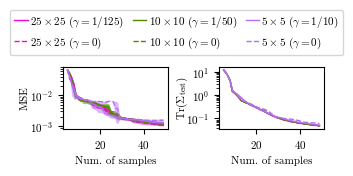

In [40]:
plt.rcParams.update({'text.usetex': False,
                     'font.family': 'serif',
                     'font.size': 8,
                     'font.serif': 'cmr10',
                     'mathtext.fontset': 'cm',
                     'axes.formatter.use_mathtext': True})

fig, ax = plt.subplots(1, 2, figsize=(3+3/8, 0.8))
plt.subplots_adjust(wspace=0.48)

a = 5 
b = 45 + 5
mean_mse_der_sequential = np.mean(gp_der_mse_Xu25_g125, axis=0)
std_mse_der_sequential = np.std(gp_der_mse_Xu25_g125, ddof=1, axis=0)
ax[0].plot(np.arange(a, b), mean_mse_der_sequential, linewidth=1, color='#F505DE', label=r'$25 \times 25$ ($\gamma=1/125$)')
ax[0].fill_between(np.arange(a, b), 
                   mean_mse_der_sequential-std_mse_der_sequential, 
                   mean_mse_der_sequential+std_mse_der_sequential,
                   color='#F505DE', linewidth=0, alpha=0.5)

mean_mse_der_sequential = np.mean(gp_der_mse_Xu25_g0, axis=0)
std_mse_der_sequential = np.std(gp_der_mse_Xu25_g0, ddof=1, axis=0)
ax[0].plot(np.arange(a, b), mean_mse_der_sequential, linewidth=1, color='#F505DE', label=r'$25 \times 25$ ($\gamma=0$)', linestyle='--')
ax[0].fill_between(np.arange(a, b), 
                   mean_mse_der_sequential-std_mse_der_sequential, 
                   mean_mse_der_sequential+std_mse_der_sequential,
                   color='#F505DE', linewidth=0, alpha=0.5)

mean_mse_der_sequential = np.mean(gp_der_mse_Xu10_g50, axis=0)
std_mse_der_sequential = np.std(gp_der_mse_Xu10_g50, ddof=1, axis=0)
ax[0].plot(np.arange(a, b), mean_mse_der_sequential, linewidth=1, color='#538900', label=r'$10 \times 10$ ($\gamma=1/50$)')
ax[0].fill_between(np.arange(a, b), 
                   mean_mse_der_sequential-std_mse_der_sequential, 
                   mean_mse_der_sequential+std_mse_der_sequential,
                   color='#538900', linewidth=0, alpha=0.5)

mean_mse_der_sequential = np.mean(gp_der_mse_Xu10_g0, axis=0)
std_mse_der_sequential = np.std(gp_der_mse_Xu10_g0, ddof=1, axis=0)
ax[0].plot(np.arange(a, b), mean_mse_der_sequential, linewidth=1, color='#538900', label=r'$10 \times 10$ ($\gamma=0$)', linestyle='--')
ax[0].fill_between(np.arange(a, b), 
                   mean_mse_der_sequential-std_mse_der_sequential, 
                   mean_mse_der_sequential+std_mse_der_sequential,
                   color='#538900', linewidth=0, alpha=0.5)

mean_mse_der_sequential = np.mean(gp_der_mse_Xu5_g10, axis=0)
std_mse_der_sequential = np.std(gp_der_mse_Xu5_g10, ddof=1, axis=0)
ax[0].plot(np.arange(a, b), mean_mse_der_sequential, linewidth=1, color='#B66EF5', label=r'$5 \times 5$ ($\gamma=1/10$)')
ax[0].fill_between(np.arange(a, b), 
                   mean_mse_der_sequential-std_mse_der_sequential, 
                   mean_mse_der_sequential+std_mse_der_sequential,
                   color='#B66EF5', linewidth=0, alpha=0.5)

mean_mse_der_sequential = np.mean(gp_der_mse_Xu5_g0, axis=0)
std_mse_der_sequential = np.std(gp_der_mse_Xu5_g0, ddof=1, axis=0)
ax[0].plot(np.arange(a, b), mean_mse_der_sequential, linewidth=1, color='#B66EF5', label=r'$5 \times 5$ ($\gamma=0$)', linestyle='--')
ax[0].fill_between(np.arange(a, b), 
                   mean_mse_der_sequential-std_mse_der_sequential, 
                   mean_mse_der_sequential+std_mse_der_sequential,
                   color='#B66EF5', linewidth=0, alpha=0.5)


# -- BED k=1 -- #
mean_uncert_der_sequential = np.mean(gp_der_uncert_Xu25_g125, axis=0)
std_uncert_der_sequential = np.std(gp_der_uncert_Xu25_g125, ddof=1, axis=0)
ax[1].plot(np.arange(a, b), mean_uncert_der_sequential, linewidth=1, color='#F505DE')
ax[1].fill_between(np.arange(a, b), 
                   mean_uncert_der_sequential-std_uncert_der_sequential, 
                   mean_uncert_der_sequential+std_uncert_der_sequential,
                   color='#F505DE', linewidth=0, alpha=0.5)

mean_uncert_der_sequential = np.mean(gp_der_uncert_Xu25_g0, axis=0)
std_uncert_der_sequential = np.std(gp_der_uncert_Xu25_g0, ddof=1, axis=0)
ax[1].plot(np.arange(a, b), mean_uncert_der_sequential, linewidth=1, color='#F505DE', linestyle='--')
ax[1].fill_between(np.arange(a, b), 
                   mean_uncert_der_sequential-std_uncert_der_sequential, 
                   mean_uncert_der_sequential+std_uncert_der_sequential,
                   color='#F505DE', linewidth=0, alpha=0.5)

mean_uncert_der_sequential = np.mean(gp_der_uncert_Xu10_g50, axis=0)
std_uncert_der_sequential = np.std(gp_der_uncert_Xu10_g50, ddof=1, axis=0)
ax[1].plot(np.arange(a, b), mean_uncert_der_sequential, linewidth=1, color='#538900')
ax[1].fill_between(np.arange(a, b), 
                   mean_uncert_der_sequential-std_uncert_der_sequential, 
                   mean_uncert_der_sequential+std_uncert_der_sequential,
                   color='#538900', linewidth=0, alpha=0.5)

mean_uncert_der_sequential = np.mean(gp_der_uncert_Xu10_g0, axis=0)
std_uncert_der_sequential = np.std(gp_der_uncert_Xu10_g0, ddof=1, axis=0)
ax[1].plot(np.arange(a, b), mean_uncert_der_sequential, linewidth=1, color='#538900', linestyle='--')
ax[1].fill_between(np.arange(a, b), 
                   mean_uncert_der_sequential-std_uncert_der_sequential, 
                   mean_uncert_der_sequential+std_uncert_der_sequential,
                   color='#538900', linewidth=0, alpha=0.5)

mean_uncert_der_sequential = np.mean(gp_der_uncert_Xu5_g10, axis=0)
std_uncert_der_sequential = np.std(gp_der_uncert_Xu5_g10, ddof=1, axis=0)
ax[1].plot(np.arange(a, b), mean_uncert_der_sequential, linewidth=1, color='#B66EF5')
ax[1].fill_between(np.arange(a, b), 
                   mean_uncert_der_sequential-std_uncert_der_sequential, 
                   mean_uncert_der_sequential+std_uncert_der_sequential,
                   color='#B66EF5', linewidth=0, alpha=0.5)

mean_uncert_der_sequential = np.mean(gp_der_uncert_Xu5_g0, axis=0)
std_uncert_der_sequential = np.std(gp_der_uncert_Xu5_g0, ddof=1, axis=0)
ax[1].plot(np.arange(a, b), mean_uncert_der_sequential, linewidth=1, color='#B66EF5', linestyle='--')
ax[1].fill_between(np.arange(a, b), 
                   mean_uncert_der_sequential-std_uncert_der_sequential, 
                   mean_uncert_der_sequential+std_uncert_der_sequential,
                   color='#B66EF5', linewidth=0, alpha=0.5)

ax[0].legend(handlelength=1.2, ncol=3, columnspacing=0.8, handletextpad=0.2, loc=(-0.5, 1.2))

for i in range(2):
    ax[i].set_xlabel("Num. of samples")

ax[0].set_ylabel("MSE", labelpad=0)
ax[1].set_ylabel("Tr($\Sigma_{\mathrm{test}}$)", labelpad=-3)
    
ax[0].set_yscale('log')
ax[1].set_yscale('log')

plt.savefig("hep2d_BED_derGP_XuChoice.pdf", bbox_inches="tight", pad_inches=0.1, dpi=400)

plt.show()

# Figure 10 (c)

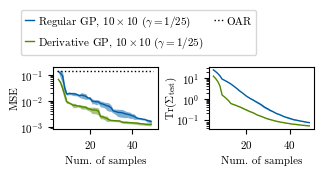

In [47]:
plt.rcParams.update({'text.usetex': False,
                     'font.family': 'serif',
                     'font.size': 8,
                     'font.serif': 'cmr10',
                     'mathtext.fontset': 'cm',
                     'axes.formatter.use_mathtext': True})

fig, ax = plt.subplots(1, 2, figsize=(3+3/8, 0.8))
plt.subplots_adjust(wspace=0.48)

a = 5 
b = 45 + 5

mean_mse_reg_sequential = np.mean(gp_reg_mse_Xu10_g50, axis=0)
std_mse_reg_sequential = np.std(gp_reg_mse_Xu10_g50, ddof=1, axis=0)
ax[0].plot(np.arange(a, b), mean_mse_reg_sequential, linewidth=1, color='#005EA7', label=r'Regular GP, $10 \times 10$ ($\gamma=1/25$)')
ax[0].fill_between(np.arange(a, b), 
                   mean_mse_reg_sequential-std_mse_reg_sequential, 
                   mean_mse_reg_sequential+std_mse_reg_sequential,
                   color='#005EA7', linewidth=0, alpha=0.5)

mean_mse_der_sequential = np.mean(gp_der_mse_Xu10_g50, axis=0)
std_mse_der_sequential = np.std(gp_der_mse_Xu10_g50, ddof=1, axis=0)
ax[0].plot(np.arange(a, b), mean_mse_der_sequential, linewidth=1, color='#538900', label=r'Derivative GP, $10 \times 10$ ($\gamma=1/25$)')
ax[0].fill_between(np.arange(a, b), 
                   mean_mse_der_sequential-std_mse_der_sequential, 
                   mean_mse_der_sequential+std_mse_der_sequential,
                   color='#538900', linewidth=0, alpha=0.5)

ax[0].hlines(mse_OAR, 4.5, 50, color='black', linestyle='dotted', linewidth=1, label=r'OAR')


mean_uncert_reg_sequential = np.mean(gp_reg_uncert_Xu10_g50, axis=0)
std_uncert_reg_sequential = np.std(gp_reg_uncert_Xu10_g50, ddof=1, axis=0)
ax[1].plot(np.arange(a, b), mean_uncert_reg_sequential, linewidth=1, color='#005EA7')
ax[1].fill_between(np.arange(a, b), 
                   mean_uncert_reg_sequential-std_uncert_reg_sequential, 
                   mean_uncert_reg_sequential+std_uncert_reg_sequential,
                   color='#005EA7', linewidth=0, alpha=0.5)

mean_uncert_der_sequential = np.mean(gp_der_uncert_Xu10_g50, axis=0)
std_uncert_der_sequential = np.std(gp_der_uncert_Xu10_g50, ddof=1, axis=0)
ax[1].plot(np.arange(a, b), mean_uncert_der_sequential, linewidth=1, color='#538900')
ax[1].fill_between(np.arange(a, b), 
                   mean_uncert_der_sequential-std_uncert_der_sequential, 
                   mean_uncert_der_sequential+std_uncert_der_sequential,
                   color='#538900', linewidth=0, alpha=0.5)

for i in range(2):
    ax[i].set_xlabel("Num. of samples")

ax[0].legend(handlelength=0.8, ncol=2, columnspacing=1, handletextpad=0.3, loc=(-0.3, 1.2))

ax[0].set_ylabel("MSE", labelpad=0)
ax[1].set_ylabel("Tr($\Sigma_{\mathrm{test}}$)", labelpad=-2)
    
ax[0].set_yscale('log')
ax[1].set_yscale('log')

plt.savefig("hep2d_BED_derGP_vs_regGP.pdf", bbox_inches="tight", pad_inches=0.1, dpi=400)
plt.show()

# Figure 11 (a)

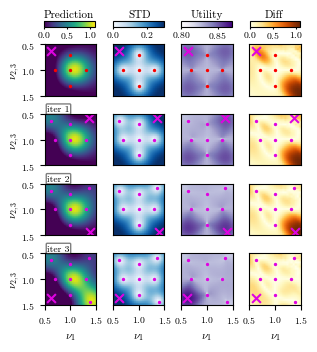

In [49]:
plt.rcParams.update({'text.usetex': False,
                    'font.family': 'serif',
                    'font.size': 7,
                    'font.serif': 'cmr10',
                    'mathtext.fontset': 'cm',
                    'axes.formatter.use_mathtext': True})

n_plots = 4
fig, ax = plt.subplots(n_plots, 4, figsize=(3+3/8, 0.8*11/2.6), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.2, hspace=0.35)
res = int(np.sqrt(np.shape(X_test)[0]))
extent = [X_lower, X_upper, X_upper, X_lower]

# -- Utility input --------------------------------------------------------- #
lin = np.linspace(X_lower, X_upper, 10)
nuJ1_util, nuJ23_util = np.meshgrid(lin, lin)
X_util = np.vstack((nuJ1_util.flatten(), nuJ23_util.flatten())).T
# -------------------------------------------------------------------------- #

kernel = RegularKernel(amplitude=amplitude, length_scale=length_scale, noise_level=noise_level)
gp_reg = GaussianProcessRegressor(kernel=kernel, optimizer=None, random_state=42)
gp_reg.fit(X_train, y_train)

y_pred, std = gp_reg.predict(X_test, return_std=True)
_, cov = gp_reg.predict(X_test, return_cov=True)

im0 = ax[0][0].imshow(y_pred.ravel().reshape(res, res), origin='upper', extent=extent, cmap='viridis', vmin=0, vmax=1.1)     
im1 = ax[0][1].imshow(std.ravel().reshape(res, res), origin='upper', extent=extent, cmap='Blues', vmin=0, vmax=0.3)
acq = NetVarianceLoss(gp_reg, X_util, np.trace(cov))
util = np.array([acq.utility(x) for x in X_test])
im2 = ax[0][2].imshow(util.reshape(res, res), origin='upper', extent=extent, cmap='Purples', vmin=0.8, vmax=0.87)
im3 = ax[0][3].imshow(np.abs(y_pred.ravel() - y_test.ravel()).reshape(res, res), origin='upper', extent=extent, cmap='YlOrBr', vmin=0, vmax=1.1)
for j in range(n_plots):
    ax[0][j].scatter(gp_reg.X_train[:, 0], gp_reg.X_train[:, 1], facecolor='#FA0000', s=2)

BED_reg = GPUncertaintyOptimizer(
    gp_model=gp_reg,
    bounds={"nu_J1": (X_lower, X_upper), "nu_J23": (X_lower, X_upper)},
    function=efficiency_events,
    random_state=42,
    verbose=False,
)

for i in range(n_plots-1):
    gp_reg = BED_reg.minimize_variance(
        X_util=X_util, n_iters=1, n_restarts_optimizer=n_restarts_optimizer, gamma=0.05,
    )

    y_pred, std = gp_reg.predict(X_test, return_std=True)
    _, cov = gp_reg.predict(X_test, return_cov=True)

    im0 = ax[i+1][0].imshow(y_pred.ravel().reshape(res, res), origin='upper', extent=extent, cmap='viridis', vmin=0, vmax=1.1)     
    im1 = ax[i+1][1].imshow(std.ravel().reshape(res, res), origin='upper', extent=extent, cmap='Blues', vmin=0, vmax=0.3)
    acq = NetVarianceLoss(gp_reg, X_util, np.trace(cov))
    util = np.array([acq.utility(x) for x in X_test])
    im2 = ax[i+1][2].imshow(util.reshape(res, res), origin='upper', extent=extent, cmap='Purples', vmin=0.8, vmax=0.87)
    im3 = ax[i+1][3].imshow(np.abs(y_pred.ravel() - y_test.ravel()).reshape(res, res), origin='upper', extent=extent, cmap='YlOrBr', vmin=0, vmax=1.1)

    for j in range(n_plots):
        ax[i+1][j].scatter(gp_reg.X_train[:5, 0], gp_reg.X_train[:5, 1], facecolor='#DF03E1', s=2)
        ax[i+1][j].scatter(gp_reg.X_train[5:, 0], gp_reg.X_train[5:, 1], facecolor='#DF03E1', s=2)
    
    # next selection point 
    for j in range(4):
        ax[i][j].scatter(gp_reg.X_train[-1, 0], gp_reg.X_train[-1, 1], marker='x', facecolor='#DF03E1', s=40)

    props = dict(boxstyle='round', facecolor='white', alpha=0.5, pad=0.1)
    ax[i+1][0].text(0.55, 0.45, "iter {}".format(i+1), zorder=6, bbox=props)

gp_reg = BED_reg.minimize_variance(
        X_util=X_util, n_iters=1, n_restarts_optimizer=n_restarts_optimizer, gamma=1/25,
    )
for j in range(4):
    ax[-1][j].scatter(gp_reg.X_train[-1, 0], gp_reg.X_train[-1, 1], marker='x', facecolor='#DF03E1', s=40)

cbar_ax0 = fig.add_axes([0.132, 0.93, 0.15, 0.02])
cbar0 = fig.colorbar(im0, cax=cbar_ax0, orientation='horizontal', ticks=[0, 0.5, 1])
cbar0.ax.tick_params(labelsize=7, length=1.5, pad=0.1)

cbar_ax1 = fig.add_axes([0.335, 0.93, 0.15, 0.02])
cbar1 = fig.colorbar(im1, cax=cbar_ax1, orientation='horizontal', ticks=[0, 0.2])
cbar1.ax.tick_params(labelsize=7, length=1.5, pad=0.1)

cbar_ax2 = fig.add_axes([0.538, 0.93, 0.15, 0.02])
# cbar2 = fig.colorbar(im2, cax=cbar_ax2, orientation='horizontal', ticks=[0, 0.2])
cbar2 = fig.colorbar(im2, cax=cbar_ax2, orientation='horizontal')
cbar2.ax.tick_params(labelsize=7, length=1.5, pad=0.1)

cbar_ax3 = fig.add_axes([0.74, 0.93, 0.15, 0.02])
cbar3 = fig.colorbar(im3, cax=cbar_ax3, orientation='horizontal', ticks=[0, 0.5, 1])
cbar3.ax.tick_params(labelsize=7, length=1.5, pad=0.1)

ax[-1][0].set_xlabel(r"$\nu_{1}$", fontsize=8)
ax[-1][1].set_xlabel(r"$\nu_{1}$", fontsize=8)
ax[-1][2].set_xlabel(r"$\nu_{1}$", fontsize=8)
ax[-1][3].set_xlabel(r"$\nu_{1}$", fontsize=8)

ax[0][0].set_ylabel(r"$\nu_{2,3}$", fontsize=8, labelpad=-1)
ax[1][0].set_ylabel(r"$\nu_{2,3}$", fontsize=8, labelpad=-1)
ax[2][0].set_ylabel(r"$\nu_{2,3}$", fontsize=8, labelpad=-1)
ax[3][0].set_ylabel(r"$\nu_{2,3}$", fontsize=8, labelpad=-1)

for i in range(4):
    ax[i][1].tick_params(axis='y', left=False)
    ax[i][2].tick_params(axis='y', left=False)
    ax[i][3].tick_params(axis='y', left=False)

for i in range(4):
    ax[0][i].tick_params(axis='x', bottom=False)
    ax[1][i].tick_params(axis='x', bottom=False)
    ax[2][i].tick_params(axis='x', bottom=False)

fig.text(0.13, 0.96, r"Prediction", fontsize=8)
fig.text(0.38, 0.96, "STD", fontsize=8)
fig.text(0.565, 0.96, r"Utility", fontsize=8)
fig.text(0.785, 0.96, r"Diff", fontsize=8)

plt.savefig("hep2d_regGPR_BED.pdf", bbox_inches='tight', pad_inches=0.03, dpi=400)
plt.show()

# Figure 11 (b)

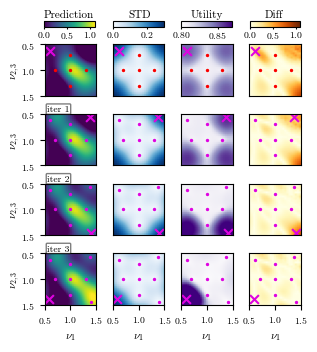

In [50]:
plt.rcParams.update({'text.usetex': False,
                    'font.family': 'serif',
                    'font.size': 7,
                    'font.serif': 'cmr10',
                    'mathtext.fontset': 'cm',
                    'axes.formatter.use_mathtext': True})

n_plots = 4
fig, ax = plt.subplots(n_plots, 4, figsize=(3+3/8, 0.8*11/2.6), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.2, hspace=0.35)
res = int(np.sqrt(np.shape(X_test)[0]))
extent = [X_lower, X_upper, X_upper, X_lower]

kernel = DerivativeKernel(amplitude=amplitude, length_scale=length_scale, noise_level=noise_level, noise_level_der=noise_level_der)
gp_der = GaussianProcessRegressor(kernel=kernel, optimizer=None, random_state=42)
gp_der.fit(X_train, y_train, X_train, dy_train)

y_pred, std = gp_der.predict(X_test, return_std=True)
_, cov = gp_der.predict(X_test, return_cov=True)

im0 = ax[0][0].imshow(y_pred.ravel().reshape(res, res), origin='upper', extent=extent, cmap='viridis', vmin=0, vmax=1.1)     
im1 = ax[0][1].imshow(std.ravel().reshape(res, res), origin='upper', extent=extent, cmap='Blues', vmin=0, vmax=0.3)
acq = NetVarianceLoss(gp_der, X_util, np.trace(cov))
util = np.array([acq.utility(x) for x in X_test])
im2 = ax[0][2].imshow(util.reshape(res, res), origin='upper', extent=extent, cmap='Purples', vmin=0.8, vmax=0.87)
im3 = ax[0][3].imshow(np.abs(y_pred.ravel() - y_test.ravel()).reshape(res, res), origin='upper', extent=extent, cmap='YlOrBr', vmin=0, vmax=1.1)
for j in range(n_plots):
    ax[0][j].scatter(gp_der.X_train[:, 0], gp_der.X_train[:, 1], facecolor='#FA0000', s=2)

BED_reg = GPUncertaintyOptimizer(
    gp_model=gp_der,
    bounds={"nu_J1": (X_lower, X_upper), "nu_J23": (X_lower, X_upper)},
    function=efficiency_events,
    der_function=der_efficiency_events_sigmoid10,
    random_state=42,
    verbose=False,
)

for i in range(n_plots-1):
    gp_der = BED_reg.minimize_variance(
        X_util=X_util, n_iters=1, n_restarts_optimizer=n_restarts_optimizer, gamma=0.05,
    )

    y_pred, std = gp_der.predict(X_test, return_std=True)
    _, cov = gp_der.predict(X_test, return_cov=True)

    im0 = ax[i+1][0].imshow(y_pred.ravel().reshape(res, res), origin='upper', extent=extent, cmap='viridis', vmin=0, vmax=1.1)     
    im1 = ax[i+1][1].imshow(std.ravel().reshape(res, res), origin='upper', extent=extent, cmap='Blues', vmin=0, vmax=0.3)
    acq = NetVarianceLoss(gp_der, X_util, np.trace(cov))
    util = np.array([acq.utility(x) for x in X_test])
    im2 = ax[i+1][2].imshow(util.reshape(res, res), origin='upper', extent=extent, cmap='Purples', vmin=0.8, vmax=0.87)
    im3 = ax[i+1][3].imshow(np.abs(y_pred.ravel() - y_test.ravel()).reshape(res, res), origin='upper', extent=extent, cmap='YlOrBr', vmin=0, vmax=1.1)

    for j in range(n_plots):
        ax[i+1][j].scatter(gp_der.X_train[:5, 0], gp_der.X_train[:5, 1], facecolor='#DF03E1', s=2)
        ax[i+1][j].scatter(gp_der.X_train[5:, 0], gp_der.X_train[5:, 1], facecolor='#DF03E1', s=2)
    
    # next selection point 
    for j in range(4):
        ax[i][j].scatter(gp_der.X_train[-1, 0], gp_der.X_train[-1, 1], marker='x', facecolor='#DF03E1', s=40)

    props = dict(boxstyle='round', facecolor='white', alpha=0.5, pad=0.1)
    ax[i+1][0].text(0.55, 0.45, "iter {}".format(i+1), zorder=6, bbox=props)

gp_der = BED_reg.minimize_variance(
        X_util=X_util, n_iters=1, n_restarts_optimizer=n_restarts_optimizer, gamma=1/25,
    )
for j in range(4):
    ax[-1][j].scatter(gp_der.X_train[-1, 0], gp_der.X_train[-1, 1], marker='x', facecolor='#DF03E1', s=40)

cbar_ax0 = fig.add_axes([0.132, 0.93, 0.15, 0.02])
cbar0 = fig.colorbar(im0, cax=cbar_ax0, orientation='horizontal', ticks=[0, 0.5, 1])
cbar0.ax.tick_params(labelsize=7, length=1.5, pad=0.1)

cbar_ax1 = fig.add_axes([0.335, 0.93, 0.15, 0.02])
cbar1 = fig.colorbar(im1, cax=cbar_ax1, orientation='horizontal', ticks=[0, 0.2])
cbar1.ax.tick_params(labelsize=7, length=1.5, pad=0.1)

cbar_ax2 = fig.add_axes([0.538, 0.93, 0.15, 0.02])
# cbar2 = fig.colorbar(im2, cax=cbar_ax2, orientation='horizontal', ticks=[0, 0.2])
cbar2 = fig.colorbar(im2, cax=cbar_ax2, orientation='horizontal')
cbar2.ax.tick_params(labelsize=7, length=1.5, pad=0.1)

cbar_ax3 = fig.add_axes([0.74, 0.93, 0.15, 0.02])
cbar3 = fig.colorbar(im3, cax=cbar_ax3, orientation='horizontal', ticks=[0, 0.5, 1])
cbar3.ax.tick_params(labelsize=7, length=1.5, pad=0.1)

ax[-1][0].set_xlabel(r"$\nu_{1}$", fontsize=8)
ax[-1][1].set_xlabel(r"$\nu_{1}$", fontsize=8)
ax[-1][2].set_xlabel(r"$\nu_{1}$", fontsize=8)
ax[-1][3].set_xlabel(r"$\nu_{1}$", fontsize=8)

ax[0][0].set_ylabel(r"$\nu_{2,3}$", fontsize=8, labelpad=-1)
ax[1][0].set_ylabel(r"$\nu_{2,3}$", fontsize=8, labelpad=-1)
ax[2][0].set_ylabel(r"$\nu_{2,3}$", fontsize=8, labelpad=-1)
ax[3][0].set_ylabel(r"$\nu_{2,3}$", fontsize=8, labelpad=-1)

for i in range(4):
    ax[i][1].tick_params(axis='y', left=False)
    ax[i][2].tick_params(axis='y', left=False)
    ax[i][3].tick_params(axis='y', left=False)

for i in range(4):
    ax[0][i].tick_params(axis='x', bottom=False)
    ax[1][i].tick_params(axis='x', bottom=False)
    ax[2][i].tick_params(axis='x', bottom=False)

fig.text(0.13, 0.96, r"Prediction", fontsize=8)
fig.text(0.38, 0.96, "STD", fontsize=8)
fig.text(0.565, 0.96, r"Utility", fontsize=8)
fig.text(0.785, 0.96, r"Diff", fontsize=8)

plt.savefig("hep2d_derGPR_BED.pdf", bbox_inches='tight', pad_inches=0.03, dpi=400)
plt.show()

# Figure 12 (a)

In [51]:
def random_sampling_regGP(seed, n):
    np.random.seed(seed)
    gp_reg_mse = np.zeros((n, 45))
    gp_reg_uncert = np.zeros((n, 45))

    for i in range(n):
        kernel = RegularKernel(amplitude=amplitude, length_scale=length_scale, noise_level=noise_level)
        gp_reg = GaussianProcessRegressor(kernel=kernel, optimizer=None, random_state=42+i)
        gp_reg.fit(X_train, y_train)

        y_pred, std = gp_reg.predict(X_test, return_std=True)
        _, cov = gp_reg.predict(X_test, return_cov=True)
        gp_reg_mse[i, 0] = np.mean((y_test.ravel() - y_pred.ravel())**2)
        gp_reg_uncert[i, 0] = np.trace(cov)

        X_sampled = X_train
        y_sampled = y_train
        for j in range(44):
            X_it = np.random.uniform(X_lower, X_upper, (1, X_train.shape[1]))
            y_it = efficiency_events(X_it[0])
            y_it = np.array(y_it).reshape(-1,)
            X_sampled = np.concatenate((X_sampled, X_it), axis=0)
            y_sampled = np.concatenate((y_sampled, y_it), axis=0)
            gp_reg.fit(X_sampled, y_sampled)
            y_pred, std = gp_reg.predict(X_test, return_std=True)
            _, cov = gp_reg.predict(X_test, return_cov=True)
            gp_reg_mse[i, j+1] = np.mean((y_test.ravel() - y_pred.ravel())**2)
            gp_reg_uncert[i, j+1] = np.trace(cov)
    return gp_reg_mse, gp_reg_uncert

In [52]:
def grid_sampling_regGP():
    gp_reg_mse = np.zeros((1, 6))
    gp_reg_uncert = np.zeros((1, 6))

    kernel = RegularKernel(amplitude=amplitude, length_scale=length_scale, noise_level=noise_level)
    gp_reg = GaussianProcessRegressor(kernel=kernel, optimizer=None, random_state=42)
    gp_reg.fit(X_train, y_train)

    y_pred, std = gp_reg.predict(X_test, return_std=True)
    _, cov = gp_reg.predict(X_test, return_cov=True)
    gp_reg_mse[0, 0] = np.mean((y_test.ravel() - y_pred.ravel())**2)
    gp_reg_uncert[0, 0] = np.trace(cov)

    X_sampled = X_train
    y_sampled = y_train

    for i in range(2, 7):
        ln = np.linspace(np.array((X_lower, X_lower)), np.array((X_upper, X_upper)), num=i)
        X_it = np.array(np.meshgrid(*ln.T)).reshape(2, i**2).T
        y_it = Pool(cpu_count()).map(efficiency_events, X_it)
        y_it = np.array(y_it).reshape(-1,)
        X_sampled = np.concatenate((X_train, X_it), axis=0)
        y_sampled = np.concatenate((y_train, y_it), axis=0)

        gp_reg.fit(X_sampled, y_sampled)
        y_pred, std = gp_reg.predict(X_test, return_std=True)
        _, cov = gp_reg.predict(X_test, return_cov=True)
        gp_reg_mse[0, i-1] = np.mean((y_test.ravel() - y_pred.ravel())**2)
        gp_reg_uncert[0, i-1] = np.trace(cov)
    return gp_reg_mse, gp_reg_uncert

In [53]:
gp_reg_mse_random, gp_reg_uncert_random = random_sampling_regGP(seed=42, n=10)
gp_reg_mse_grid, gp_reg_uncert_grid = grid_sampling_regGP()

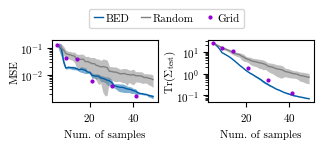

In [54]:
plt.rcParams.update({'text.usetex': False,
                     'font.family': 'serif',
                     'font.size': 8,
                     'font.serif': 'cmr10',
                     'mathtext.fontset': 'cm',
                     'axes.formatter.use_mathtext': True})

fig, ax = plt.subplots(1, 2, figsize=(3+3/8, 0.8))
plt.subplots_adjust(wspace=0.48)

# -- MSE -- #
mean_mse_reg_sequential = np.mean(gp_reg_mse_Xu10_g50, axis=0)
std_mse_reg_sequential = np.std(gp_reg_mse_Xu10_g50, ddof=1, axis=0)
ax[0].plot(np.arange(a, b), mean_mse_reg_sequential, linewidth=1, color='#005EA7', label=r'BED')
ax[0].fill_between(np.arange(a, b), 
                   mean_mse_reg_sequential-std_mse_reg_sequential, 
                   mean_mse_reg_sequential+std_mse_reg_sequential,
                   color='#005EA7', linewidth=0, alpha=0.5)

mean_mse_reg_random = np.mean(gp_reg_mse_random, axis=0)
std_mse_reg_random = np.std(gp_reg_mse_random, ddof=1, axis=0)
ax[0].plot(np.arange(a, b), mean_mse_reg_random, linewidth=1, color='gray', label=r'Random')
ax[0].fill_between(np.arange(a, b), 
                   mean_mse_reg_random-std_mse_reg_random, 
                   mean_mse_reg_random+std_mse_reg_random,
                   color='gray', linewidth=0, alpha=0.5)

ax[0].plot(np.array([5+i**2 for i in [0, 2, 3, 4, 5, 6]]), gp_reg_mse_grid.ravel(), label='Grid', 
           color='darkviolet', zorder=5, linewidth=0, marker='o', ms=2)

# -- Uncert -- $
mean_uncert_reg_sequential = np.mean(gp_reg_uncert_Xu10_g50, axis=0)
std_uncert_reg_sequential = np.std(gp_reg_uncert_Xu10_g50, ddof=1, axis=0)
ax[1].plot(np.arange(a, b), mean_uncert_reg_sequential, linewidth=1, color='#005EA7', label=r'BED')
ax[1].fill_between(np.arange(a, b), 
                   mean_uncert_reg_sequential-std_uncert_reg_sequential, 
                   mean_uncert_reg_sequential+std_uncert_reg_sequential,
                   color='#005EA7', linewidth=0, alpha=0.5)

mean_uncert_reg_random = np.mean(gp_reg_uncert_random, axis=0)
std_uncert_reg_random = np.std(gp_reg_uncert_random, ddof=1, axis=0)
ax[1].plot(np.arange(a, b), mean_uncert_reg_random, linewidth=1, color='gray', label=r'Random')
ax[1].fill_between(np.arange(a, b), 
                   mean_uncert_reg_random-std_uncert_reg_random, 
                   mean_uncert_reg_random+std_uncert_reg_random,
                   color='gray', linewidth=0, alpha=0.5)

ax[1].plot(np.array([5+i**2 for i in [0, 2, 3, 4, 5, 6]]), gp_reg_uncert_grid.ravel(), label='Grid', 
           color='darkviolet', zorder=5, linewidth=0, marker='o', ms=2)

for i in range(2):
    ax[i].set_xlabel("Num. of samples")

ax[0].legend(handlelength=0.8, ncol=3, columnspacing=1, handletextpad=0.3, loc=(0.35, 1.2))

ax[0].set_ylabel("MSE", labelpad=0)
ax[1].set_ylabel("Tr($\Sigma_{\mathrm{test}}$)", labelpad=-2)
    
ax[0].set_yscale('log')
ax[1].set_yscale('log')

plt.savefig("hep2d_BED_regGP_vs_all.pdf", bbox_inches="tight", pad_inches=0.1, dpi=400)

plt.show()

# Figure 12 (b)

In [61]:
def random_sampling_derGP(seed, n):
    np.random.seed(seed)
    gp_der_mse = np.zeros((n, 45))
    gp_der_uncert = np.zeros((n, 45))

    for i in range(n):
        kernel = DerivativeKernel(amplitude=amplitude, length_scale=length_scale, noise_level=noise_level, noise_level_der=noise_level_der)
        gp_der = GaussianProcessRegressor(kernel=kernel, optimizer=None, random_state=42+i)
        gp_der.fit(X_train, y_train, X_train, dy_train)

        y_pred, std = gp_der.predict(X_test, return_std=True)
        _, cov = gp_der.predict(X_test, return_cov=True)
        gp_der_mse[i, 0] = np.mean((y_test.ravel() - y_pred.ravel())**2)
        gp_der_uncert[i, 0] = np.trace(cov)

        X_sampled = X_train
        y_sampled = y_train
        dy_sampled = dy_train
        for j in range(44):
            X_it = np.random.uniform(X_lower, X_upper, (1, X_train.shape[1]))
            y_it = efficiency_events(X_it[0])
            y_it = np.array(y_it).reshape(1,)
            dy_it = der_efficiency_events_sigmoid10(X_it[0])
            dy_it = np.array(dy_it).reshape(1, 2)
            X_sampled = np.concatenate((X_sampled, X_it), axis=0)
            y_sampled = np.concatenate((y_sampled, y_it), axis=0)
            dy_sampled = np.concatenate((dy_sampled, dy_it), axis=0)
            gp_der.fit(X_sampled, y_sampled, X_sampled, dy_sampled)
            y_pred, std = gp_der.predict(X_test, return_std=True)
            _, cov = gp_der.predict(X_test, return_cov=True)
            gp_der_mse[i, j+1] = np.mean((y_test.ravel() - y_pred.ravel())**2)
            gp_der_uncert[i, j+1] = np.trace(cov)
    return gp_der_mse, gp_der_uncert

In [63]:
def grid_sampling_derGP():
    gp_der_mse = np.zeros((1, 6))
    gp_der_uncert = np.zeros((1, 6))

    kernel = DerivativeKernel(amplitude=amplitude, length_scale=length_scale, noise_level=noise_level, noise_level_der=noise_level_der)
    gp_der = GaussianProcessRegressor(kernel=kernel, optimizer=None, random_state=42)
    gp_der.fit(X_train, y_train, X_train, dy_train)

    y_pred, std = gp_der.predict(X_test, return_std=True)
    _, cov = gp_der.predict(X_test, return_cov=True)
    gp_der_mse[0, 0] = np.mean((y_test.ravel() - y_pred.ravel())**2)
    gp_der_uncert[0, 0] = np.trace(cov)

    X_sampled = X_train
    y_sampled = y_train
    dy_sampled = dy_train
    for i in range(2, 7):
        ln = np.linspace(np.array((X_lower, X_lower)), np.array((X_upper, X_upper)), num=i)
        X_it = np.array(np.meshgrid(*ln.T)).reshape(2, i**2).T
        y_it = Pool(cpu_count()).map(efficiency_events, X_it)
        y_it = np.array(y_it).reshape(-1,)
        dy_it = Pool(cpu_count()).map(der_efficiency_events_sigmoid10, X_it)
        dy_it = np.array(dy_it).reshape(-1, 2)
        X_sampled = np.concatenate((X_train, X_it), axis=0)
        y_sampled = np.concatenate((y_train, y_it), axis=0)
        dy_sampled = np.concatenate((dy_train, dy_it), axis=0)

        gp_der.fit(X_sampled, y_sampled, X_sampled, dy_sampled)
        y_pred, std = gp_der.predict(X_test, return_std=True)
        _, cov = gp_der.predict(X_test, return_cov=True)
        gp_der_mse[0, i-1] = np.mean((y_test.ravel() - y_pred.ravel())**2)
        gp_der_uncert[0, i-1] = np.trace(cov)
    return gp_der_mse, gp_der_uncert

In [64]:
gp_der_mse_random, gp_der_uncert_random = random_sampling_derGP(seed=42, n=10)
gp_der_mse_grid, gp_der_uncert_grid = grid_sampling_derGP()

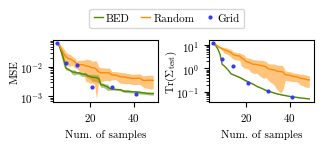

In [65]:
plt.rcParams.update({'text.usetex': False,
                     'font.family': 'serif',
                     'font.size': 8,
                     'font.serif': 'cmr10',
                     'mathtext.fontset': 'cm',
                     'axes.formatter.use_mathtext': True})

fig, ax = plt.subplots(1, 2, figsize=(3+3/8, 0.8))
plt.subplots_adjust(wspace=0.48)

# -- MSE -- #
mean_mse_der_sequential = np.mean(gp_der_mse_Xu10_g50, axis=0)
std_mse_der_sequential = np.std(gp_der_mse_Xu10_g50, ddof=1, axis=0)
ax[0].plot(np.arange(a, b), mean_mse_der_sequential, linewidth=1, color='#538900', label=r'BED')
ax[0].fill_between(np.arange(a, b), 
                   mean_mse_der_sequential-std_mse_der_sequential, 
                   mean_mse_der_sequential+std_mse_der_sequential,
                   color='#538900', linewidth=0, alpha=0.5)

mean_mse_der_random = np.mean(gp_der_mse_random, axis=0)
std_mse_der_random = np.std(gp_der_mse_random, ddof=1, axis=0)
ax[0].plot(np.arange(a, b), mean_mse_der_random, linewidth=1, color='darkorange', label=r'Random')
ax[0].fill_between(np.arange(a, b), 
                   mean_mse_der_random-std_mse_der_random, 
                   mean_mse_der_random+std_mse_der_random,
                   color='darkorange', linewidth=0, alpha=0.5)

ax[0].plot(np.array([5+i**2 for i in [0, 2, 3, 4, 5, 6]]), gp_der_mse_grid.ravel(), label='Grid', 
           color='#3439F3', zorder=5, linewidth=0, marker='o', ms=2)

# -- Uncert -- $
mean_uncert_der_sequential = np.mean(gp_der_uncert_Xu10_g50, axis=0)
std_uncert_der_sequential = np.std(gp_der_uncert_Xu10_g50, ddof=1, axis=0)
ax[1].plot(np.arange(a, b), mean_uncert_der_sequential, linewidth=1, color='#538900', label=r'BED')
ax[1].fill_between(np.arange(a, b), 
                   mean_uncert_der_sequential-std_uncert_der_sequential, 
                   mean_uncert_der_sequential+std_uncert_der_sequential,
                   color='#538900', linewidth=0, alpha=0.5)

mean_uncert_der_random = np.mean(gp_der_uncert_random, axis=0)
std_uncert_der_random = np.std(gp_der_uncert_random, ddof=1, axis=0)
ax[1].plot(np.arange(a, b), mean_uncert_der_random, linewidth=1, color='darkorange', label=r'Random')
ax[1].fill_between(np.arange(a, b), 
                   mean_uncert_der_random-std_uncert_der_random, 
                   mean_uncert_der_random+std_uncert_der_random,
                   color='darkorange', linewidth=0, alpha=0.5)

ax[1].plot(np.array([5+i**2 for i in [0, 2, 3, 4, 5, 6]]), gp_der_uncert_grid.ravel(), label='Grid', 
           color='#3439F3', zorder=5, linewidth=0, marker='o', ms=2)

for i in range(2):
    ax[i].set_xlabel("Num. of samples")

ax[0].legend(handlelength=0.8, ncol=3, columnspacing=1, handletextpad=0.3, loc=(0.35, 1.2))

ax[0].set_ylabel("MSE", labelpad=0)
ax[1].set_ylabel("Tr($\Sigma_{\mathrm{test}}$)", labelpad=-2)
    
ax[0].set_yscale('log')
ax[1].set_yscale('log')

plt.savefig("hep2d_BED_derGP_vs_all.pdf", bbox_inches="tight", pad_inches=0.1, dpi=400)

plt.show()

# Appendix - Random

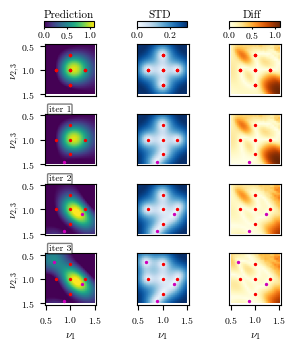

In [66]:
plt.rcParams.update({'text.usetex': False,
                     'font.family': 'serif',
                     'font.size': 7,
                     'font.serif': 'cmr10',
                     'mathtext.fontset': 'cm',
                     'axes.formatter.use_mathtext': True})

fig, ax = plt.subplots(4, 3, figsize=(3+3/8, 0.8*11/2.6), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.2, hspace=0.35)
res = int(np.sqrt(np.shape(X_test)[0]))
extent = [0.5, 1.5, 1.5, 0.5]

np.random.seed(42)
kernel = RegularKernel(amplitude=amplitude, length_scale=length_scale, noise_level=noise_level)
gp_reg = GaussianProcessRegressor(kernel=kernel, optimizer=None)
gp_reg.fit(X_train, y_train)

y_pred, std = gp_reg.predict(X_test, return_std=True)
_, cov = gp_reg.predict(X_test, return_cov=True)

im0 = ax[0][0].imshow(y_pred.ravel().reshape(res, res), origin='upper', extent=extent, cmap='viridis', vmin=0, vmax=1.1)
im1 = ax[0][1].imshow(std.ravel().reshape(res, res), origin='upper', extent=extent, cmap='Blues', vmin=0, vmax=0.3)
im2 = ax[0][2].imshow(np.abs(y_pred.ravel() - y_test.ravel()).reshape(res, res), origin='upper', extent=extent, cmap='YlOrBr', vmin=0, vmax=1.1)

np.random.seed(42)
X_sampled = X_train
y_sampled = y_train
for i in range(3):
    X_it = np.random.uniform(X_lower, X_upper, size=(1, 2))
    y_it = efficiency_events(X_it)
    X_sampled = np.concatenate((X_sampled, X_it), axis=0)    
    y_sampled = np.hstack((y_sampled, y_it))
    gp_reg.fit(X=X_sampled, y=y_sampled)
    y_pred, std_pred = gp_reg.predict(X_test, return_std=True)

    props = dict(boxstyle='round', facecolor='white', alpha=0.5, pad=0.1)
    ax[i+1][0].text(0.55, 0.42, "iter {}".format(1 + i), zorder=6, bbox=props)

    im0 = ax[i+1][0].imshow(y_pred.ravel().reshape(res, res), origin='upper', extent=extent, cmap='viridis', vmin=0, vmax=1.1)
    im1 = ax[i+1][1].imshow(std_pred.ravel().reshape(res, res), origin='upper', extent=extent, cmap='Blues', vmin=0, vmax=0.3)
    im2 = ax[i+1][2].imshow(np.abs(y_pred.ravel() - y_test.ravel()).reshape(res, res), origin='upper', extent=extent, cmap='YlOrBr', vmin=0, vmax=1.1)

    for j in range(3):
        ax[0][j].scatter(X_sampled[:5, 0], X_sampled[:5, 1], facecolor='#FA0000', s=2)
        ax[i+1][j].scatter(X_sampled[:5, 0], X_sampled[:5, 1], facecolor='#FA0000', s=2)
        ax[i+1][j].scatter(X_sampled[5:, 0], X_sampled[5:, 1], facecolor='#CD00BA', s=2)
        ax[0][j].set_xlim(0.47, 1.53)
        ax[i+1][j].set_xlim(0.47, 1.53)
        ax[0][j].set_ylim(1.53, 0.47)
        ax[i+1][j].set_ylim(1.53, 0.47)

cbar_ax0 = fig.add_axes([0.16, 0.93, 0.15, 0.02])
cbar0 = fig.colorbar(im0, cax=cbar_ax0, orientation='horizontal', ticks=[0, 0.5, 1])
cbar0.ax.tick_params(labelsize=7, length=1.5, pad=0.1)

cbar_ax1 = fig.add_axes([0.435, 0.93, 0.15, 0.02])
cbar1 = fig.colorbar(im1, cax=cbar_ax1, orientation='horizontal', ticks=[0, 0.2])
cbar1.ax.tick_params(labelsize=7, length=1.5, pad=0.1)

cbar_ax2 = fig.add_axes([0.71, 0.93, 0.15, 0.02])
cbar2 = fig.colorbar(im2, cax=cbar_ax2, orientation='horizontal', ticks=[0, 0.5, 1])
cbar2.ax.tick_params(labelsize=7, length=1.5, pad=0.1)

ax[-1][0].set_xlabel(r"$\nu_{1}$", fontsize=8)
ax[-1][1].set_xlabel(r"$\nu_{1}$", fontsize=8)
ax[-1][2].set_xlabel(r"$\nu_{1}$", fontsize=8)

ax[0][0].set_ylabel(r"$\nu_{2,3}$", fontsize=8, labelpad=-1)
ax[1][0].set_ylabel(r"$\nu_{2,3}$", fontsize=8, labelpad=-1)
ax[2][0].set_ylabel(r"$\nu_{2,3}$", fontsize=8, labelpad=-1)
ax[3][0].set_ylabel(r"$\nu_{2,3}$", fontsize=8, labelpad=-1)

for i in range(4):
    ax[i][1].tick_params(axis='y', left=False)
    ax[i][2].tick_params(axis='y', left=False)
    
for i in range(3):
    ax[0][i].tick_params(axis='x', bottom=False)
    ax[1][i].tick_params(axis='x', bottom=False)
    ax[2][i].tick_params(axis='x', bottom=False)

fig.text(0.16, 0.96, r"Prediction", fontsize=8)
fig.text(0.47, 0.96, "STD", fontsize=8)
fig.text(0.75, 0.96, r"Diff", fontsize=8)

plt.savefig("hep2d_regGPR_random.pdf", bbox_inches='tight', pad_inches=0.03, dpi=400)
plt.show()

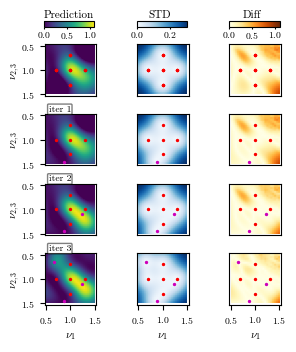

In [67]:
plt.rcParams.update({'text.usetex': False,
                     'font.family': 'serif',
                     'font.size': 7,
                     'font.serif': 'cmr10',
                     'mathtext.fontset': 'cm',
                     'axes.formatter.use_mathtext': True})

fig, ax = plt.subplots(4, 3, figsize=(3+3/8, 0.8*11/2.6), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.2, hspace=0.35)
res = int(np.sqrt(np.shape(X_test)[0]))
extent = [0.5, 1.5, 1.5, 0.5]

np.random.seed(42)
kernel = DerivativeKernel(amplitude=amplitude, length_scale=length_scale, noise_level=noise_level, noise_level_der=noise_level_der)
gp_der = GaussianProcessRegressor(kernel=kernel, optimizer=None)
gp_der.fit(X_train, y_train, X_train, dy_train)

y_pred, std = gp_der.predict(X_test, return_std=True)
_, cov = gp_der.predict(X_test, return_cov=True)

im0 = ax[0][0].imshow(y_pred.ravel().reshape(res, res), origin='upper', extent=extent, cmap='viridis', vmin=0, vmax=1.1)
im1 = ax[0][1].imshow(std.ravel().reshape(res, res), origin='upper', extent=extent, cmap='Blues', vmin=0, vmax=0.3)
im2 = ax[0][2].imshow(np.abs(y_pred.ravel() - y_test.ravel()).reshape(res, res), origin='upper', extent=extent, cmap='YlOrBr', vmin=0, vmax=1.1)

np.random.seed(42)
X_sampled = X_train
y_sampled = y_train
dy_sampled = dy_train
for i in range(3):
    X_it = np.random.uniform(X_lower, X_upper, size=(1, 2))
    y_it = efficiency_events(X_it)
    dy_it = der_efficiency_events_sigmoid10(X_it).reshape(1, 2)
    X_sampled = np.concatenate((X_sampled, X_it), axis=0)    
    y_sampled = np.hstack((y_sampled, y_it))
    dy_sampled = np.vstack((dy_sampled, dy_it))
    gp_der.fit(X=X_sampled, y=y_sampled, dX=X_sampled, dy=dy_sampled)
    y_pred, std_pred = gp_der.predict(X_test, return_std=True)

    props = dict(boxstyle='round', facecolor='white', alpha=0.5, pad=0.1)
    ax[i+1][0].text(0.55, 0.42, "iter {}".format(1 + i), zorder=6, bbox=props)

    im0 = ax[i+1][0].imshow(y_pred.ravel().reshape(res, res), origin='upper', extent=extent, cmap='viridis', vmin=0, vmax=1.1)
    im1 = ax[i+1][1].imshow(std_pred.ravel().reshape(res, res), origin='upper', extent=extent, cmap='Blues', vmin=0, vmax=0.3)
    im2 = ax[i+1][2].imshow(np.abs(y_pred.ravel() - y_test.ravel()).reshape(res, res), origin='upper', extent=extent, cmap='YlOrBr', vmin=0, vmax=1.1)

    for j in range(3):
        ax[0][j].scatter(X_sampled[:5, 0], X_sampled[:5, 1], facecolor='#FA0000', s=2)
        ax[i+1][j].scatter(X_sampled[:5, 0], X_sampled[:5, 1], facecolor='#FA0000', s=2)
        ax[i+1][j].scatter(X_sampled[5:, 0], X_sampled[5:, 1], facecolor='#CD00BA', s=2)
        ax[0][j].set_xlim(0.47, 1.53)
        ax[i+1][j].set_xlim(0.47, 1.53)
        ax[0][j].set_ylim(1.53, 0.47)
        ax[i+1][j].set_ylim(1.53, 0.47)

cbar_ax0 = fig.add_axes([0.16, 0.93, 0.15, 0.02])
cbar0 = fig.colorbar(im0, cax=cbar_ax0, orientation='horizontal', ticks=[0, 0.5, 1])
cbar0.ax.tick_params(labelsize=7, length=1.5, pad=0.1)

cbar_ax1 = fig.add_axes([0.435, 0.93, 0.15, 0.02])
cbar1 = fig.colorbar(im1, cax=cbar_ax1, orientation='horizontal', ticks=[0, 0.2])
cbar1.ax.tick_params(labelsize=7, length=1.5, pad=0.1)

cbar_ax2 = fig.add_axes([0.71, 0.93, 0.15, 0.02])
cbar2 = fig.colorbar(im2, cax=cbar_ax2, orientation='horizontal', ticks=[0, 0.5, 1])
cbar2.ax.tick_params(labelsize=7, length=1.5, pad=0.1)

ax[-1][0].set_xlabel(r"$\nu_{1}$", fontsize=8)
ax[-1][1].set_xlabel(r"$\nu_{1}$", fontsize=8)
ax[-1][2].set_xlabel(r"$\nu_{1}$", fontsize=8)

ax[0][0].set_ylabel(r"$\nu_{2,3}$", fontsize=8, labelpad=-1)
ax[1][0].set_ylabel(r"$\nu_{2,3}$", fontsize=8, labelpad=-1)
ax[2][0].set_ylabel(r"$\nu_{2,3}$", fontsize=8, labelpad=-1)
ax[3][0].set_ylabel(r"$\nu_{2,3}$", fontsize=8, labelpad=-1)

for i in range(4):
    ax[i][1].tick_params(axis='y', left=False)
    ax[i][2].tick_params(axis='y', left=False)
    
for i in range(3):
    ax[0][i].tick_params(axis='x', bottom=False)
    ax[1][i].tick_params(axis='x', bottom=False)
    ax[2][i].tick_params(axis='x', bottom=False)

fig.text(0.16, 0.96, r"Prediction", fontsize=8)
fig.text(0.47, 0.96, "STD", fontsize=8)
fig.text(0.75, 0.96, r"Diff", fontsize=8)

plt.savefig("hep2d_derGPR_random.pdf", bbox_inches='tight', pad_inches=0.03, dpi=400)
plt.show()

# Appendix - Uniform

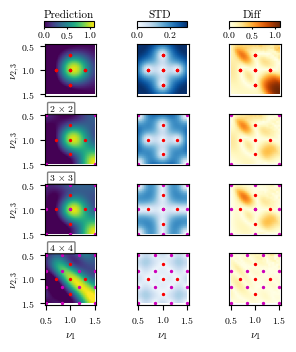

In [68]:
plt.rcParams.update({'text.usetex': False,
                     'font.family': 'serif',
                     'font.size': 7,
                     'font.serif': 'cmr10',
                     'mathtext.fontset': 'cm',
                     'axes.formatter.use_mathtext': True})

fig, ax = plt.subplots(4, 3, figsize=(3+3/8, 0.8*11/2.6), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.2, hspace=0.35)
res = int(np.sqrt(np.shape(X_test)[0]))
extent = [0.5, 1.5, 1.5, 0.5]

np.random.seed(42)
kernel = RegularKernel(amplitude=amplitude, length_scale=length_scale, noise_level=noise_level)
gp_reg = GaussianProcessRegressor(kernel=kernel, optimizer=None)
gp_reg.fit(X_train, y_train)

y_pred, std = gp_reg.predict(X_test, return_std=True)
_, cov = gp_reg.predict(X_test, return_cov=True)

im0 = ax[0][0].imshow(y_pred.ravel().reshape(res, res), origin='upper', extent=extent, cmap='viridis', vmin=0, vmax=1.1)
im1 = ax[0][1].imshow(std.ravel().reshape(res, res), origin='upper', extent=extent, cmap='Blues', vmin=0, vmax=0.3)
im2 = ax[0][2].imshow(np.abs(y_pred.ravel() - y_test.ravel()).reshape(res, res), origin='upper', extent=extent, cmap='YlOrBr', vmin=0, vmax=1.1)

for i, gsize in enumerate([2, 3, 4]):
    ln = np.linspace(np.array((X_lower, X_lower)),
                     np.array((X_upper, X_upper)),
                     num=gsize)
    X_it = np.array(np.meshgrid(*ln.T)).reshape(2, (gsize)**2).T
    y_it = np.array([efficiency_events(X_it[j]) for j in range(len(X_it))])
    y_it = np.array(y_it).reshape(-1, 1)
    X_sampled = np.concatenate((X_train, X_it), axis=0)
    y_sampled = np.concatenate((y_train.reshape(-1, 1), y_it), axis=0)
    gp_reg.fit(X=X_sampled, y=y_sampled)
    y_pred, std_pred = gp_reg.predict(X_test, return_std=True)

    props = dict(boxstyle='round', facecolor='white', alpha=0.5, pad=0.1)
    ax[i+1][0].text(0.55, 0.42, "{} $\\times$ {}".format(gsize, gsize), zorder=6, bbox=props)

    im0 = ax[i+1][0].imshow(y_pred.ravel().reshape(res, res), origin='upper', extent=extent, cmap='viridis', vmin=0, vmax=1.1)
    im1 = ax[i+1][1].imshow(std_pred.ravel().reshape(res, res), origin='upper', extent=extent, cmap='Blues', vmin=0, vmax=0.3)
    im2 = ax[i+1][2].imshow(np.abs(y_pred.ravel() - y_test.ravel()).reshape(res, res), origin='upper', extent=extent, cmap='YlOrBr', vmin=0, vmax=1.1)

    for j in range(3):
        ax[0][j].scatter(X_sampled[:5, 0], X_sampled[:5, 1], facecolor='#FA0000', s=2)
        ax[i+1][j].scatter(X_sampled[:5, 0], X_sampled[:5, 1], facecolor='#FA0000', s=2)
        ax[i+1][j].scatter(X_sampled[5:, 0], X_sampled[5:, 1], facecolor='#CD00BA', s=2)
        ax[0][j].set_xlim(0.47, 1.53)
        ax[i+1][j].set_xlim(0.47, 1.53)
        ax[0][j].set_ylim(1.53, 0.47)
        ax[i+1][j].set_ylim(1.53, 0.47)

cbar_ax0 = fig.add_axes([0.16, 0.93, 0.15, 0.02])
cbar0 = fig.colorbar(im0, cax=cbar_ax0, orientation='horizontal', ticks=[0, 0.5, 1])
cbar0.ax.tick_params(labelsize=7, length=1.5, pad=0.1)

cbar_ax1 = fig.add_axes([0.435, 0.93, 0.15, 0.02])
cbar1 = fig.colorbar(im1, cax=cbar_ax1, orientation='horizontal', ticks=[0, 0.2])
cbar1.ax.tick_params(labelsize=7, length=1.5, pad=0.1)

cbar_ax2 = fig.add_axes([0.71, 0.93, 0.15, 0.02])
cbar2 = fig.colorbar(im2, cax=cbar_ax2, orientation='horizontal', ticks=[0, 0.5, 1])
cbar2.ax.tick_params(labelsize=7, length=1.5, pad=0.1)

ax[-1][0].set_xlabel(r"$\nu_{1}$", fontsize=8)
ax[-1][1].set_xlabel(r"$\nu_{1}$", fontsize=8)
ax[-1][2].set_xlabel(r"$\nu_{1}$", fontsize=8)

ax[0][0].set_ylabel(r"$\nu_{2,3}$", fontsize=8, labelpad=-1)
ax[1][0].set_ylabel(r"$\nu_{2,3}$", fontsize=8, labelpad=-1)
ax[2][0].set_ylabel(r"$\nu_{2,3}$", fontsize=8, labelpad=-1)
ax[3][0].set_ylabel(r"$\nu_{2,3}$", fontsize=8, labelpad=-1)

for i in range(4):
    ax[i][1].tick_params(axis='y', left=False)
    ax[i][2].tick_params(axis='y', left=False)
    
for i in range(3):
    ax[0][i].tick_params(axis='x', bottom=False)
    ax[1][i].tick_params(axis='x', bottom=False)
    ax[2][i].tick_params(axis='x', bottom=False)

fig.text(0.16, 0.96, r"Prediction", fontsize=8)
fig.text(0.47, 0.96, "STD", fontsize=8)
fig.text(0.75, 0.96, r"Diff", fontsize=8)

plt.savefig("hep2d_regGPR_grid.pdf", bbox_inches='tight', pad_inches=0.03, dpi=400)
plt.show()

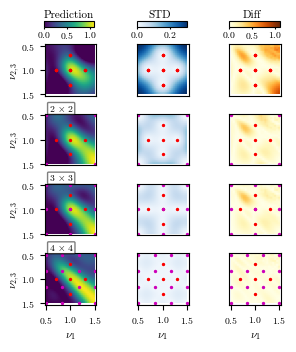

In [69]:
plt.rcParams.update({'text.usetex': False,
                     'font.family': 'serif',
                     'font.size': 7,
                     'font.serif': 'cmr10',
                     'mathtext.fontset': 'cm',
                     'axes.formatter.use_mathtext': True})

fig, ax = plt.subplots(4, 3, figsize=(3+3/8, 0.8*11/2.6), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.2, hspace=0.35)
res = int(np.sqrt(np.shape(X_test)[0]))
extent = [0.5, 1.5, 1.5, 0.5]

np.random.seed(42)
kernel = DerivativeKernel(amplitude=amplitude, length_scale=length_scale, noise_level=noise_level, noise_level_der=noise_level_der)
gp_der = GaussianProcessRegressor(kernel=kernel, optimizer=None)
gp_der.fit(X_train, y_train, X_train, dy_train)

y_pred, std = gp_der.predict(X_test, return_std=True)
_, cov = gp_der.predict(X_test, return_cov=True)

im0 = ax[0][0].imshow(y_pred.ravel().reshape(res, res), origin='upper', extent=extent, cmap='viridis', vmin=0, vmax=1.1)
im1 = ax[0][1].imshow(std.ravel().reshape(res, res), origin='upper', extent=extent, cmap='Blues', vmin=0, vmax=0.3)
im2 = ax[0][2].imshow(np.abs(y_pred.ravel() - y_test.ravel()).reshape(res, res), origin='upper', extent=extent, cmap='YlOrBr', vmin=0, vmax=1.1)

for i, gsize in enumerate([2, 3, 4]):
    ln = np.linspace(np.array((X_lower, X_lower)),
                     np.array((X_upper, X_upper)),
                     num=gsize)
    X_it = np.array(np.meshgrid(*ln.T)).reshape(2, (gsize)**2).T
    y_it = np.array([efficiency_events(X_it[j]) for j in range(len(X_it))])
    y_it = np.array(y_it).reshape(-1, 1)
    dy_it = np.array([der_efficiency_events_sigmoid10(X_it[j]) for j in range(len(X_it))]).reshape(-1, 2)
    X_sampled = np.concatenate((X_train, X_it), axis=0)
    y_sampled = np.concatenate((y_train.reshape(-1, 1), y_it), axis=0)
    dy_sampled = np.concatenate((dy_train, dy_it), axis=0)
    gp_der.fit(X=X_sampled, y=y_sampled, dX=X_sampled, dy=dy_sampled)
    y_pred, std_pred = gp_der.predict(X_test, return_std=True)

    props = dict(boxstyle='round', facecolor='white', alpha=0.5, pad=0.1)
    ax[i+1][0].text(0.55, 0.42, "{} $\\times$ {}".format(gsize, gsize), zorder=6, bbox=props)

    im0 = ax[i+1][0].imshow(y_pred.ravel().reshape(res, res), origin='upper', extent=extent, cmap='viridis', vmin=0, vmax=1.1)
    im1 = ax[i+1][1].imshow(std_pred.ravel().reshape(res, res), origin='upper', extent=extent, cmap='Blues', vmin=0, vmax=0.3)
    im2 = ax[i+1][2].imshow(np.abs(y_pred.ravel() - y_test.ravel()).reshape(res, res), origin='upper', extent=extent, cmap='YlOrBr', vmin=0, vmax=1.1)

    for j in range(3):
        ax[0][j].scatter(X_sampled[:5, 0], X_sampled[:5, 1], facecolor='#FA0000', s=2)
        ax[i+1][j].scatter(X_sampled[:5, 0], X_sampled[:5, 1], facecolor='#FA0000', s=2)
        ax[i+1][j].scatter(X_sampled[5:, 0], X_sampled[5:, 1], facecolor='#CD00BA', s=2)
        ax[0][j].set_xlim(0.47, 1.53)
        ax[i+1][j].set_xlim(0.47, 1.53)
        ax[0][j].set_ylim(1.53, 0.47)
        ax[i+1][j].set_ylim(1.53, 0.47)

cbar_ax0 = fig.add_axes([0.16, 0.93, 0.15, 0.02])
cbar0 = fig.colorbar(im0, cax=cbar_ax0, orientation='horizontal', ticks=[0, 0.5, 1])
cbar0.ax.tick_params(labelsize=7, length=1.5, pad=0.1)

cbar_ax1 = fig.add_axes([0.435, 0.93, 0.15, 0.02])
cbar1 = fig.colorbar(im1, cax=cbar_ax1, orientation='horizontal', ticks=[0, 0.2])
cbar1.ax.tick_params(labelsize=7, length=1.5, pad=0.1)

cbar_ax2 = fig.add_axes([0.71, 0.93, 0.15, 0.02])
cbar2 = fig.colorbar(im2, cax=cbar_ax2, orientation='horizontal', ticks=[0, 0.5, 1])
cbar2.ax.tick_params(labelsize=7, length=1.5, pad=0.1)

ax[-1][0].set_xlabel(r"$\nu_{1}$", fontsize=8)
ax[-1][1].set_xlabel(r"$\nu_{1}$", fontsize=8)
ax[-1][2].set_xlabel(r"$\nu_{1}$", fontsize=8)

ax[0][0].set_ylabel(r"$\nu_{2,3}$", fontsize=8, labelpad=-1)
ax[1][0].set_ylabel(r"$\nu_{2,3}$", fontsize=8, labelpad=-1)
ax[2][0].set_ylabel(r"$\nu_{2,3}$", fontsize=8, labelpad=-1)
ax[3][0].set_ylabel(r"$\nu_{2,3}$", fontsize=8, labelpad=-1)

for i in range(4):
    ax[i][1].tick_params(axis='y', left=False)
    ax[i][2].tick_params(axis='y', left=False)
    
for i in range(3):
    ax[0][i].tick_params(axis='x', bottom=False)
    ax[1][i].tick_params(axis='x', bottom=False)
    ax[2][i].tick_params(axis='x', bottom=False)

fig.text(0.16, 0.96, r"Prediction", fontsize=8)
fig.text(0.47, 0.96, "STD", fontsize=8)
fig.text(0.75, 0.96, r"Diff", fontsize=8)

plt.savefig("hep2d_derGPR_grid.pdf", bbox_inches='tight', pad_inches=0.03, dpi=400)
plt.show()